# XGBoostによる特徴量評価について

- 多クラス分類の識別で、重要とみなされたものは他人と区別するのに有用な特徴量であるはずというスタンスで行う。
- 以前,ランダムフォレストで行った記憶があるが、決定木ベースだとXGBoostのが良さげみたいなので、試しに実施

参考文献   
[1]Y. Ouadjer, M. Adnane and N. Bouadjenek, "Feature Importance Evaluation of Smartphone Touch Gestures for Biometric Authentication," 2020 2nd International Workshop on Human-Centric Smart Environments for Health and Well-being (IHSH), 2021, pp. 103-107, doi: 10.1109/IHSH51661.2021.9378750.

## XGBoostとは

- eXtreme Gradient Boostingの略(2014年に発表された手法)
- 勾配ブースティング木と呼ばれるアンサンブル学習と決定木を組み合わせた手法
    - アンサンブル学習
        - 弱学習器を複数用いて総合的に結果を出力(バギングとブースティングがある)   
        - バギング
            - 並列に決定木モデルを扱ってそれぞれのモデルの結果を総合的に判断
            - ランダムフォレスト   
        - ブースティング
            - 直列に決定木を作成
            - 最初の学習器で上手く分類・推定できなかった部分に対して重みを付けて次の弱学習器で学習を行う
            - 最終的に、各モデルに対して精度の高さを基に重み付けをして集約し、モデルを作成する
            - XGBoost
    - 決定木
        - 木構造でデータ分類していく手法
- デフォルトのXGBoost
    - 木の生成 : ブースティング(逐次的な生成)
    - 評価基準 : ジニ係数と正則化項との和
    - 変数決定 : histogram-based(変数を定められた数に量子化し、ビンごとに閾値として探索する)の貪欲法
    - 重みづけ : 二次近似を行うニュートン法によって最適化

- アルゴリズム
\begin{equation*} L(y_{i}, \hat{y}_{i})=\sum\limits_{i=1}^{m}[y_{i}\ln(1+e^{-\hat{y}_{i}})+(1-y_{i})\ln(1+e^{-\hat{y}_{i}})] \tag{1} \end{equation*}

- 手順[5]
    - ① 回帰木を学習させる
    - ② ①の予測値と目的地から計算される目的関数を改善するように、新たな回帰木を学習させ、モデルに追加する
    - ③ ②を指定した回帰木の本数の分だけ繰り返す
    - ④ モデルの予測値はデータが各回帰木に属する葉の重みの合計値
       
②の補足   
追加される2本目以降の木は、目的変数とそれまでに作成した回帰木の予測値との誤差に対して学習が行われる。<br>そのため、木を追加するたびにモデルの予測値が目的値に合致していくが、深い木を作ったときに過学習する可能性がある。<br>そこで、モデルを学習する際に正則化項を追加し、パラメータが過大にならないように抑制している

### XGBoostで使用される変数


||変数名|説明|
|:----|:----|:----|
|共通変数| booster|デフォルト=gbtree<br>gbtree もしくは gblinear のいずれかを使用|
||silent|デフォルト=0<br>0 にすると起動中のメッセージを出力し、1 にすると出力しない|
||nthread|デフォルトは使用可能なスレッドの最大数<br>xgboost を使用時の並列処理を行うスレッドの数|
||num_pbuffer|自動的に設定される<br>予測バッファのサイズで、たいていトレーニングデータ数で設定される。<br>ブースティングの最後の段階で予測の結果を保存するために使用|
||num_feature|自動的に設定される<br>ブースティングに使用する特徴次元の数で、その特徴次元の最大数に設定される|
|gbtree固有の変数|eta|デフォルト=0.3<br>ステップサイズの縮小幅で、オーバーフィッティングを防ぐために使用される。<br>各ブースティングのステップ終了後に、新しい特徴の重みを直接入手可能|
||gamma|損失還元(loss reduction)の最小値で、木の葉ノードをさらに分割する際に必要な値。値を大きくすると、そのアルゴリズムはより強固になる。|
||max_depth|default=6<br>木の深さの最大値|
||min_child_weight|default=1<br>子ノードにおける必要な最小の重み。<br>木の分割段階で、ある葉ノードにおける重みの合計値がmin_child_weight 未満であれば、それ以上分割しない<br>例：線形回帰の場合には、各ノードに必要な例の最小値に対応している。<br>値を大きくするとそのアルゴリズムはより強固になる。|
||max_delta_step|default=0<br>値を0に設定した場合、特になにもしない<br>もし正の値にした場合には、ステップの更新でより強固に(柔軟性がない) する。<br>このパラメータは必要でないことが多いが、クラスのバランスが著しく悪いときのロジスティック回帰で役立つかもしれない。<br>値を1～10に設定すると良い|
||subsample|default=1<br>サブサンプルを生成する際のトレーニングデータの抽出割合<br>例：0.5に設定すると、XGBoost はデータの半分をランダムに選んで木を成長させることで、オーバーフィッティングを防ぐ|
||colsample_bytree|default=1<br>各木を作成するときの列におけるサブサンプルの割合|
|gblinear固有の変数|lambda|L2 正則化の重み項|
||alpha|L1 正則化の重み項|
||lambda_bias|L2 正則化のバイアス項で、デフォルト値は0 (L1正則化のバイアス項は重要でないためない)|
|タスク変数|objective|default=reg:linear<br>学習方法を明確にする<br>"reg:linear" --線形回帰<br>"reg:logistic" --ロジスティック回帰<br>"binary:logistic" --2-クラス分類向けのロジスティック回帰で、確率を出力<br>"binary:logitraw" --2-クラス分類向けのロジスティック回帰で、ロジスティック回帰式に代入する前の値<br>"multi:softmax" --XGBoost をソフトマックス関数を使用した多クラス分類に設定します。変数num_class (クラスの数)も設定する必要がある<br>"multi:softprob" --softmax と同じであるが、各データがどのクラスに属するかの予測確率が出力される<br>"rank:pairwise" --順位付けをペアワイズ損失が最小になるようにXGBoost を設定|
||base_score|default=0.5<br>すべての例に対する初めの予測スコアでグローバルバイアス|
||eval_metric|default according to objective<br>検証データに対する評価基準で、デフォルトの基準はobjective によって決まる。回帰であればrmse、クラス分類であればerror、順位付けではmean average precision がデフォルトとなる。<br>"rmse": 2乗平均平方根誤差<br>"logloss": 負の対数尤度<br>"error": 2-クラス分類のエラー率。(分類の誤ったケース数) / (すべてのケース数) で計算される。 例：予測において、この評価値は0.5 よりも大きければ予測は良い例であり、0.5 よりも小さい場合には悪い例となる。<br>"merror": 多クラス分類のエラー率。(誤認したケースの数) / (すべてのケース数).<br>"mlogloss": 多クラスの対数損失<br>"auc": Area under the curve の略でROC曲線下の面積で、性能の良さを表します<br>"ndcg":Normalized Discounted Cumulative Gain の略で順位付け問題の性能評価に用いられる<br>"map": Mean average precision の略|
||seed|default=0<br>乱数シード値|
|コンソール変数|use_buffer|default=1 <br>テキストからの入力のためにバイナリバッファを作るかどうかで、たいていの場合データの読み込みのスピードが改善する|
||num_round|ブースティングを行う回数|
||data|トレーニングデータのパス|
||test:data|予測する用のテストデータのパス|


強固になるの意味は、外れ値に強くなるという意味と汎化性能が低くなるの両方の意味を込めている[4]   

### XGBoostの特徴

- 精度が比較的高い
- 特徴量は数値
- 特徴量のスケーリングの必要がない
    - 決定木では各特徴量について値の大小関係のみが問題となるため
- 実装が楽
- どの特徴量が重要か調査可能
- ハイパーパラメータのチューニングに時間がかかる？

## XGBoostのFeature_importanceについて(2021/06/29追加)
参考サイト[3]   

### importance type
変数重要度   
デフォルト: weight(調べた結果コレだった)→ver1.5.0からはgainらしい   
平均ではなく合計をとったtotal_gain,total_coverもできたとのこと
- weight
    - 生成された全ての木の中にその変数がいくつ分岐として存在するか
    - あくまで「存在する個数」しか見ていない
    - どれだけ予測に近づける分岐をしているかや、入力に対してどれだけ分岐に使用されるのかという情報はここにはない。   
- gain
    - 評価基準をどれだけ改善させたることができる(できた)のかという値
    - 各分岐においてこれが最大となる変数とその閾値を見つけるのがTree based Modelであるが、最終的に完成されたモデルにおいて、その変数が平均的にどれだけgainを与えたのかという指標
    - 例： max_depth:3・n_estimator:100であればモデル全体で分岐が合計700回起こるので、変数Xがgain=10で10回分岐に採用されたのであれば、Xのfeature_importanceは、100/7000=0.143となる。
- cover
    - 葉に分類された訓練データの二次勾配の合計値
    - 誤差関数が二乗誤差であれば単純に分類に登場した回数に対応する
    - 木の中で深い位置にあるほどこの指標は小さくなる。
    - 分類問題における"cover"を理解するには誤差関数の二次勾配について知っておく必要がある
    - 回帰問題の時にはとても直観的で「一つの入力が何度この変数によって分岐されるか」の平均がfeature_importanceとなる。

    
- まとめ
    - weight→その変数が全ての木の中にいくつ分岐点として存在するか
    - gain→その変数が平均的にどれぐらい評価基準を改善しているのか(全分岐点についての平均)
    - cover→(回帰問題では) ある入力に対して平均的に何度分岐に用いられているか(全入力についての平均)

## 特徴量評価における今後の方針

### 文献[1]の問題点

問題1. 特徴量の重要度評価を行っているが使用している特徴量に問題がある   

→frank datasetにおいて使用しないでと言われている特徴量を除いて実施(方向は考慮しない)   
→自分の場合、ストローク方向ごとに行っているので、方向ごとにわけて変化があるかみる

問題2. 最後に7つの特徴量を選択し、結果を出しているが、なぜ7つに決定したかの基準がわからない   

→可能であれば重要度評価において上位のものから1つずつ加えて精度を出してみる    
→Forward Feature Selection(重要度の高いものから順番に追加)

## 実験のパターン

問題点1について   
1. 文献[1]との結果の差をみるため同じ条件で実施
1. 文献[1]において余分な特徴量を削除して実施
1. ストロークの方向ごとに実施
    1. up
    1. down
    1. left
    1. right

問題点2について
1. ひとまずaccuracyの高い順に追加して変化をとりあえずみてみる(特徴量数は27個)

- 全部で10~12パターンくらい？
- できたらストロークを組み合わせた場合で行う

修正   
終了   
- 文献[1]との結果の差をみるため同じ条件で実施
- 文献[1]において余分な特徴量を削除して実施
未終了
- ストローク方向に分割したパターン
- 2ストローク

## 環境

In [25]:
! sw_vers

ProductName:	Mac OS X
ProductVersion:	10.14.6
BuildVersion:	18G6032


In [26]:
! python -V

Python 3.7.7


In [36]:
! pip list | grep xgboost      

xgboost                  1.4.2


## 使用するパッケージ

In [7]:
# 必要なパッケージの用意
import glob
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from sklearn import datasets

In [11]:
#現在の最大表示列数の出力
pd.get_option("display.max_columns")

#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_columns', 50)

# 練習
参考サイト[2]   

## 二値分類

[0]	train-logloss:0.46240	eval-logloss:0.49290
[1]	train-logloss:0.33344	eval-logloss:0.37602
[2]	train-logloss:0.24974	eval-logloss:0.30837
[3]	train-logloss:0.19168	eval-logloss:0.26162
[4]	train-logloss:0.15087	eval-logloss:0.22837
[5]	train-logloss:0.12011	eval-logloss:0.20208
[6]	train-logloss:0.09615	eval-logloss:0.17614
[7]	train-logloss:0.07942	eval-logloss:0.16177
[8]	train-logloss:0.06669	eval-logloss:0.15044
[9]	train-logloss:0.05665	eval-logloss:0.14649
[10]	train-logloss:0.04829	eval-logloss:0.13628
[11]	train-logloss:0.04239	eval-logloss:0.13244
[12]	train-logloss:0.03736	eval-logloss:0.12173
[13]	train-logloss:0.03319	eval-logloss:0.11718
[14]	train-logloss:0.02926	eval-logloss:0.11260
[15]	train-logloss:0.02656	eval-logloss:0.11169
[16]	train-logloss:0.02429	eval-logloss:0.11039
[17]	train-logloss:0.02263	eval-logloss:0.11370
[18]	train-logloss:0.02082	eval-logloss:0.11181
[19]	train-logloss:0.01902	eval-logloss:0.11299
[20]	train-logloss:0.01756	eval-logloss:0.11146
[2

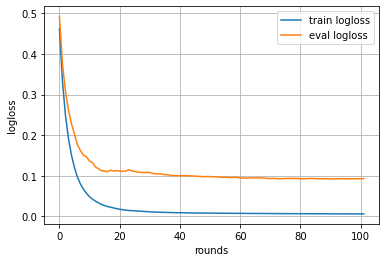

In [28]:
def main():
    # 乳がんデータセットを読み込む
    dataset = datasets.load_breast_cancer()
    X, y = dataset.data, dataset.target
    # データセットを学習用と検証用に分割する
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.3,
                                                        shuffle=True,
                                                        random_state=42,
                                                        stratify=y)
    # XGBoost が扱うデータセットの形式に直す
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    # 学習用のパラメータ
    xgb_params = {
        # 二値分類問題
        'objective': 'binary:logistic',
        # 評価指標
        'eval_metric': 'logloss',
    }
    
    # モデルを学習する
    # 学習時に用いる検証用データ
    evals = [(dtrain, 'train'), (dtest, 'eval')]
    # 学習過程を記録するための辞書
    evals_result = {}
    bst = xgb.train(xgb_params,
                    dtrain,
                    num_boost_round=1000,  # ラウンド数を増やしておく
                    # 一定ラウンド回しても改善が見込めない場合は学習を打ち切る
                    # XGBoost で early_stopping_rounds を使って学習ラウンド数を最適化する
                    early_stopping_rounds=10,
                    evals=evals,
                    evals_result=evals_result,
                    )
    
    # 検証用データが各クラスに分類される確率を計算する
    y_pred_proba = bst.predict(dtest)
    # しきい値 0.5 で 0, 1 に丸める
    y_pred = np.where(y_pred_proba > 0.5, 1, 0)
    # 精度 (Accuracy) を検証する
    acc = accuracy_score(y_test, y_pred)
    print('Accuracy:', acc)
    
    """XGBoost で学習の履歴を可視化するサンプルコード"""

    # 学習の課程を折れ線グラフとしてプロットする
    train_metric = evals_result['train']['logloss']
    plt.plot(train_metric, label='train logloss')
    eval_metric = evals_result['eval']['logloss']
    plt.plot(eval_metric, label='eval logloss')
    plt.grid()
    plt.legend()
    plt.xlabel('rounds')
    plt.ylabel('logloss')
    plt.show()


if __name__ == '__main__':
    main()

scikit-learn インターフェースを使ってみる   
XGBoost には、ネイティブな API の他に scikit-learn 互換の API を持ったインターフェースもある。   
おなじみのscikit-learn

Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.
Will train until validation_1-logloss hasn't improved in 10 rounds.
[0]	validation_0-logloss:0.46240	validation_1-logloss:0.49290
[1]	validation_0-logloss:0.33344	validation_1-logloss:0.37602
[2]	validation_0-logloss:0.24974	validation_1-logloss:0.30837
[3]	validation_0-logloss:0.19168	validation_1-logloss:0.26162
[4]	validation_0-logloss:0.15087	validation_1-logloss:0.22837
[5]	validation_0-logloss:0.12011	validation_1-logloss:0.20208
[6]	validation_0-logloss:0.09615	validation_1-logloss:0.17614
[7]	validation_0-logloss:0.07942	validation_1-logloss:0.16177
[8]	validation_0-logloss:0.06669	validation_1-logloss:0.15044
[9]	validation_0-logloss:0.05665	validation_1-logloss:0.14649
[10]	validation_0-logloss:0.04829	validation_1-logloss:0.13628
[11]	validation_0-logloss:0.04239	validation_1-logloss:0.13244
[12]	validation_0-logloss:0.03736	validation_1-logloss:0.12173
[13]	validation_0-logloss:0

/Users/otaketomomi/anaconda3/envs/TF/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/otaketomomi/anaconda3/envs/TF/lib/python3.7/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[63]	validation_0-logloss:0.00734	validation_1-logloss:0.09454
[64]	validation_0-logloss:0.00730	validation_1-logloss:0.09491
[65]	validation_0-logloss:0.00725	validation_1-logloss:0.09475
[66]	validation_0-logloss:0.00721	validation_1-logloss:0.09512
[67]	validation_0-logloss:0.00716	validation_1-logloss:0.09464
[68]	validation_0-logloss:0.00712	validation_1-logloss:0.09456
[69]	validation_0-logloss:0.00708	validation_1-logloss:0.09352
[70]	validation_0-logloss:0.00704	validation_1-logloss:0.09323
[71]	validation_0-logloss:0.00699	validation_1-logloss:0.09361
[72]	validation_0-logloss:0.00696	validation_1-logloss:0.09319
[73]	validation_0-logloss:0.00692	validation_1-logloss:0.09269
[74]	validation_0-logloss:0.00688	validation_1-logloss:0.09289
[75]	validation_0-logloss:0.00685	validation_1-logloss:0.09317
[76]	validation_0-logloss:0.00681	validation_1-logloss:0.09353
[77]	validation_0-logloss:0.00677	validation_1-logloss:0.09327
[78]	validation_0-logloss:0.00674	validation_1-logloss:

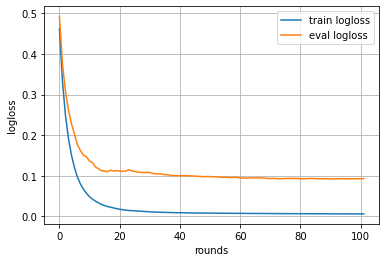

In [29]:
"""XGBoost の scikit-learn インターフェースを使ったサンプルコード (二値分類)"""


def main():
    dataset = datasets.load_breast_cancer()
    X, y = dataset.data, dataset.target

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.3,
                                                        shuffle=True,
                                                        random_state=42,
                                                        stratify=y)

    # scikit-learn API を備えた分類器
    clf = xgb.XGBClassifier(objective='binary:logistic',
                            # 'num_boost_round' の代わり
                            # adding 1 estimator per round
                            n_estimators=1000)
    # 学習する
    evals_result = {}
    clf.fit(X_train, y_train,
            # 学習に使う評価指標
            eval_metric='logloss',
            # 学習時に用いる検証用データ
            eval_set=[
                (X_train, y_train),
                (X_test, y_test),
            ],
            early_stopping_rounds=10,
            # 学習過程の記録はコールバック API で登録する
            callbacks=[
                xgb.callback.record_evaluation(evals_result)
            ],
            )

    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print('Accuracy:', acc)

    # 学習過程の名前は 'validation_{n}' になる
    train_metric = evals_result['validation_0']['logloss']
    plt.plot(train_metric, label='train logloss')
    eval_metric = evals_result['validation_1']['logloss']
    plt.plot(eval_metric, label='eval logloss')
    plt.grid()
    plt.legend()
    plt.xlabel('rounds')
    plt.ylabel('logloss')
    plt.show()


if __name__ == '__main__':
    main()

## 多値分類問題
二値分類とは学習するときのパラメータが異なる。

[0]	train-mlogloss:0.74229	eval-mlogloss:0.76578
[1]	train-mlogloss:0.53065	eval-mlogloss:0.56586
[2]	train-mlogloss:0.39291	eval-mlogloss:0.44111
[3]	train-mlogloss:0.29864	eval-mlogloss:0.35772
[4]	train-mlogloss:0.23161	eval-mlogloss:0.30303
[5]	train-mlogloss:0.18313	eval-mlogloss:0.26998
[6]	train-mlogloss:0.14774	eval-mlogloss:0.24459
[7]	train-mlogloss:0.12119	eval-mlogloss:0.22865
[8]	train-mlogloss:0.10136	eval-mlogloss:0.21806
[9]	train-mlogloss:0.08644	eval-mlogloss:0.20913
[10]	train-mlogloss:0.07479	eval-mlogloss:0.20622
[11]	train-mlogloss:0.06401	eval-mlogloss:0.20976
[12]	train-mlogloss:0.05654	eval-mlogloss:0.20498
[13]	train-mlogloss:0.05095	eval-mlogloss:0.20384
[14]	train-mlogloss:0.04637	eval-mlogloss:0.19950
[15]	train-mlogloss:0.04319	eval-mlogloss:0.19810
[16]	train-mlogloss:0.03985	eval-mlogloss:0.19591
[17]	train-mlogloss:0.03759	eval-mlogloss:0.19711
[18]	train-mlogloss:0.03585	eval-mlogloss:0.20368
[19]	train-mlogloss:0.03459	eval-mlogloss:0.20251
[20]	train

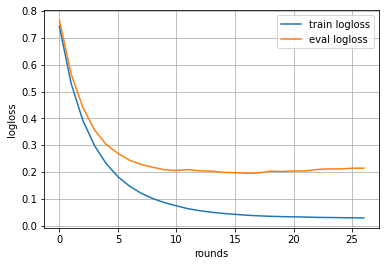

In [30]:
"""XGBoost で多値分類するサンプルコード"""


def main():
    # Iris データセットを読み込む
    dataset = datasets.load_iris()
    X, y = dataset.data, dataset.target

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.3,
                                                        shuffle=True,
                                                        random_state=42,
                                                        stratify=y)

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    xgb_params = {
        # 多値分類問題
        'objective': 'multi:softmax',
        # クラス数
        'num_class': 3,
        # 学習用の指標 (Multiclass logloss)
        'eval_metric': 'mlogloss',
    }
    evals = [(dtrain, 'train'), (dtest, 'eval')]
    evals_result = {}
    bst = xgb.train(xgb_params,
                    dtrain,
                    num_boost_round=1000,
                    early_stopping_rounds=10,
                    evals=evals,
                    evals_result=evals_result,
                    )

    y_pred = bst.predict(dtest)
    acc = accuracy_score(y_test, y_pred)
    print('Accuracy:', acc)

    train_metric = evals_result['train']['mlogloss']
    plt.plot(train_metric, label='train logloss')
    eval_metric = evals_result['eval']['mlogloss']
    plt.plot(eval_metric, label='eval logloss')
    plt.grid()
    plt.legend()
    plt.xlabel('rounds')
    plt.ylabel('logloss')
    plt.show()


if __name__ == '__main__':
    main()

得られた学習過程のグラフは次の通り。 学習用データの損失は減っているものの、検証用データの損失が減らない状況が生じていることから過学習の予兆が見られる。

## 特徴量の重要度を可視化する
XGBoost は決定木の仲間ということで特徴量の重要度 (Feature Importance) を可視化する機能を備えている。    
次のサンプルコードでは、Iris データセットの分類にどの特徴量が有効だったのかを性能のゲインにもとづいて可視化している。

[0]	train-mlogloss:0.74229	eval-mlogloss:0.76578
[1]	train-mlogloss:0.53065	eval-mlogloss:0.56586
[2]	train-mlogloss:0.39291	eval-mlogloss:0.44111
[3]	train-mlogloss:0.29864	eval-mlogloss:0.35772
[4]	train-mlogloss:0.23161	eval-mlogloss:0.30303
[5]	train-mlogloss:0.18313	eval-mlogloss:0.26998
[6]	train-mlogloss:0.14774	eval-mlogloss:0.24459
[7]	train-mlogloss:0.12119	eval-mlogloss:0.22865
[8]	train-mlogloss:0.10136	eval-mlogloss:0.21806
[9]	train-mlogloss:0.08644	eval-mlogloss:0.20913
[10]	train-mlogloss:0.07479	eval-mlogloss:0.20622
[11]	train-mlogloss:0.06401	eval-mlogloss:0.20976
[12]	train-mlogloss:0.05654	eval-mlogloss:0.20498
[13]	train-mlogloss:0.05095	eval-mlogloss:0.20384
[14]	train-mlogloss:0.04637	eval-mlogloss:0.19950
[15]	train-mlogloss:0.04319	eval-mlogloss:0.19810
[16]	train-mlogloss:0.03985	eval-mlogloss:0.19591
[17]	train-mlogloss:0.03759	eval-mlogloss:0.19711
[18]	train-mlogloss:0.03585	eval-mlogloss:0.20368
[19]	train-mlogloss:0.03459	eval-mlogloss:0.20251
[20]	train

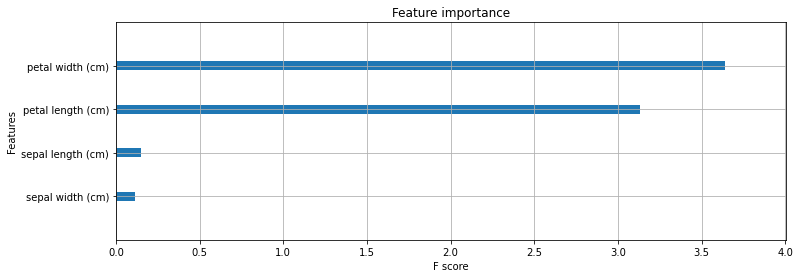

importance_type=gain, show_values: true


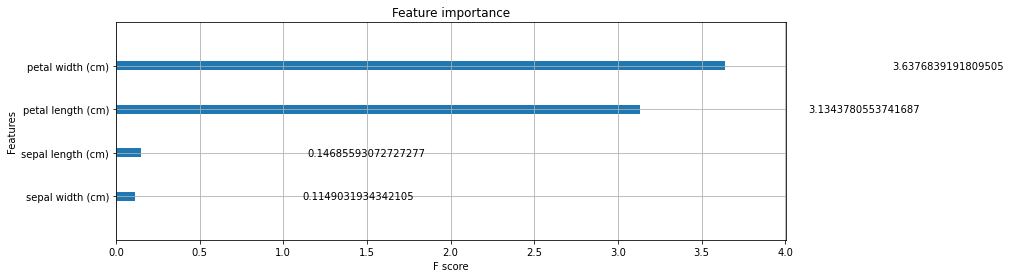

importance_type=total_gain, show_values: true


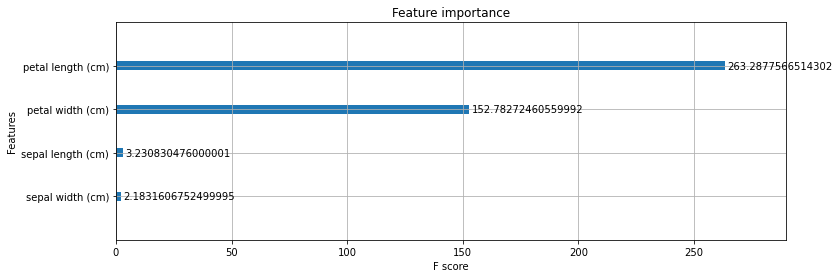

importance_type=weight, show_values: true


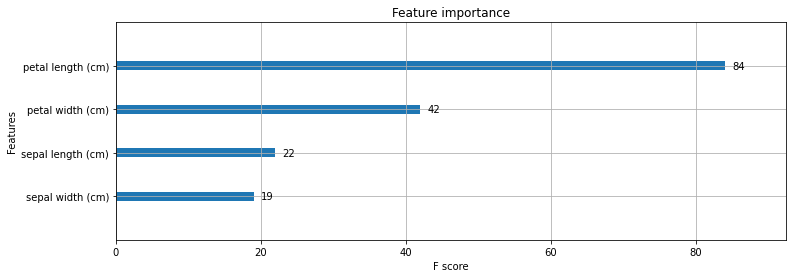

importance_type=cover, show_values: true


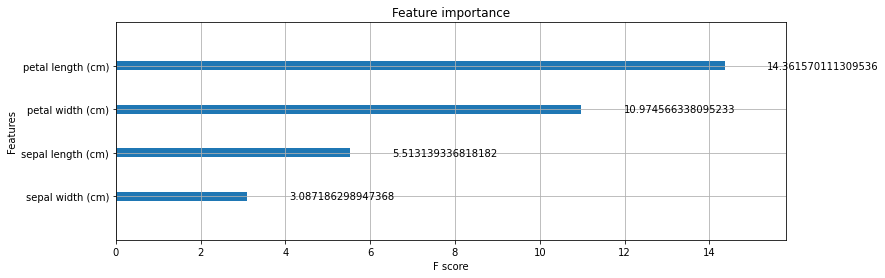

importance_type=total_cover, show_values: true


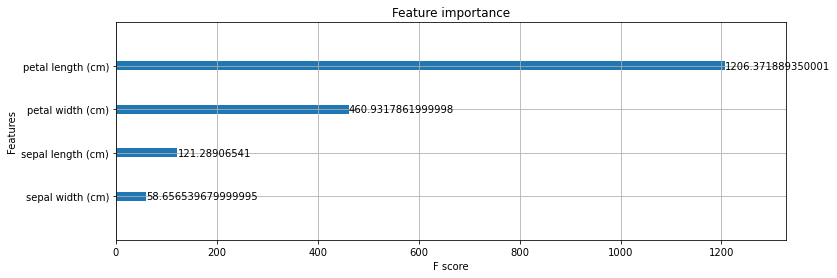

default


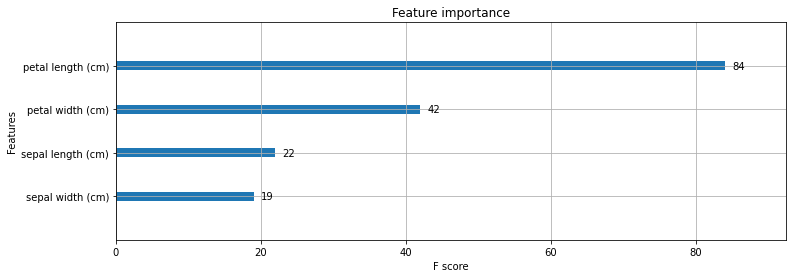

{'petal length (cm)': 84, 'petal width (cm)': 42, 'sepal length (cm)': 22, 'sepal width (cm)': 19}


In [60]:
def main():
    dataset = datasets.load_iris()
    X, y = dataset.data, dataset.target

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.3,
                                                        shuffle=True,
                                                        random_state=42,
                                                        stratify=y)

    # 可視化のために特徴量の名前を渡しておく
    dtrain = xgb.DMatrix(X_train, label=y_train,
                         feature_names=dataset.feature_names)
    dtest = xgb.DMatrix(X_test, label=y_test,
                        feature_names=dataset.feature_names)

    xgb_params = {
        'objective': 'multi:softmax',
        'num_class': 3,
        'eval_metric': 'mlogloss',
    }

    evals = [(dtrain, 'train'), (dtest, 'eval')]
    evals_result = {}
    bst = xgb.train(xgb_params,
                    dtrain,
                    num_boost_round=1000,
                    early_stopping_rounds=10,
                    evals=evals,
                    evals_result=evals_result,
                    ) 
    
#     xgb.to_graphviz(bst, num_trees=1)
    
    return bst

def result_plot_show_values_false(bst):
    # 性能向上に寄与する度合いで重要度をプロットする
    _, ax = plt.subplots(figsize=(12, 4))
    xgb.plot_importance(bst,
                        ax=ax,
                        importance_type='gain',
                        show_values=False) # Trueで数値が出てくる
    plt.show()

def result_plot_show_values_true(bst):
    # 性能向上に寄与する度合いで重要度をプロットする
    _, ax = plt.subplots(figsize=(12, 4))
    xgb.plot_importance(bst,
                        ax=ax,
                        importance_type='gain',
                        show_values=True) # Trueで数値が出てくる
    plt.show()

def result_plot_total_gain(bst):
    # 性能向上に寄与する度合いで重要度をプロットする
    _, ax = plt.subplots(figsize=(12, 4))
    xgb.plot_importance(bst,
                        ax=ax,
                        importance_type='total_gain',
                        show_values=True) # Trueで数値が出てくる
    plt.show()

def result_plot_wight(bst):
    # 性能向上に寄与する度合いで重要度をプロットする
    _, ax = plt.subplots(figsize=(12, 4))
    xgb.plot_importance(bst,
                        ax=ax,
                        importance_type='weight',
                        show_values=True)
    plt.show()

def result_plot_cover(bst):
    # 性能向上に寄与する度合いで重要度をプロットする
    _, ax = plt.subplots(figsize=(12, 4))
    xgb.plot_importance(bst,
                        ax=ax,
                        importance_type='cover',
                        show_values=True)
    plt.show()
    
def result_plot_total_cover(bst):
    # 性能向上に寄与する度合いで重要度をプロットする
    _, ax = plt.subplots(figsize=(12, 4))
    xgb.plot_importance(bst,
                        ax=ax,
                        importance_type='total_cover',
                        show_values=True)
    plt.show()

def result_plot_default(bst):
    # 性能向上に寄与する度合いで重要度をプロットする
    _, ax = plt.subplots(figsize=(12, 4))
    xgb.plot_importance(bst,
                        ax=ax)
    plt.show()
    
def bst_get_fscore(bst):
    
    # Feature Importanceの情報を持っている辞書
    print(bst.get_fscore())
    

if __name__ == '__main__':
    bst = main()
    
    print("\nimportance_type=gain, show_values: false")
    result_plot_show_values_false(bst)
    
    print("importance_type=gain, show_values: true")
    result_plot_show_values_true(bst)

    print("importance_type=total_gain, show_values: true")
    result_plot_total_gain(bst)
    
    print("importance_type=weight, show_values: true")
    result_plot_wight(bst)
    
    print("importance_type=cover, show_values: true")
    result_plot_cover(bst)
    
    print("importance_type=total_cover, show_values: true")
    result_plot_total_cover(bst)
    
    print("default")
    result_plot_default(bst)
    
    bst_get_fscore(bst)
    

petal length と petal width が分類する上で有効っぽい

## 二分木のプロット（失敗）

In [59]:
# pip install graphviz

In [61]:
from graphviz import Digraph

In [63]:
def main():
    dataset = datasets.load_iris()
    X, y = dataset.data, dataset.target

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.3,
                                                        shuffle=True,
                                                        random_state=42,
                                                        stratify=y)

    # 可視化のために特徴量の名前を渡しておく
    dtrain = xgb.DMatrix(X_train, label=y_train,
                         feature_names=dataset.feature_names)
    dtest = xgb.DMatrix(X_test, label=y_test,
                        feature_names=dataset.feature_names)

    xgb_params = {
        'objective': 'multi:softmax',
        'num_class': 3,
        'eval_metric': 'mlogloss',
    }

    evals = [(dtrain, 'train'), (dtest, 'eval')]
    evals_result = {}
    bst = xgb.train(xgb_params,
                    dtrain,
                    num_boost_round=1000,
                    early_stopping_rounds=10,
                    evals=evals,
                    evals_result=evals_result,
                    ) 
    
    return bst
    
def bst_get_fscore(bst):
    
    # Feature Importanceの情報を持っている辞書
    print(bst.get_fscore())
    

if __name__ == '__main__':
    bst = main()

[0]	train-mlogloss:0.74229	eval-mlogloss:0.76578
[1]	train-mlogloss:0.53065	eval-mlogloss:0.56586
[2]	train-mlogloss:0.39291	eval-mlogloss:0.44111
[3]	train-mlogloss:0.29864	eval-mlogloss:0.35772
[4]	train-mlogloss:0.23161	eval-mlogloss:0.30303
[5]	train-mlogloss:0.18313	eval-mlogloss:0.26998
[6]	train-mlogloss:0.14774	eval-mlogloss:0.24459
[7]	train-mlogloss:0.12119	eval-mlogloss:0.22865
[8]	train-mlogloss:0.10136	eval-mlogloss:0.21806
[9]	train-mlogloss:0.08644	eval-mlogloss:0.20913
[10]	train-mlogloss:0.07479	eval-mlogloss:0.20622
[11]	train-mlogloss:0.06401	eval-mlogloss:0.20976
[12]	train-mlogloss:0.05654	eval-mlogloss:0.20498
[13]	train-mlogloss:0.05095	eval-mlogloss:0.20384
[14]	train-mlogloss:0.04637	eval-mlogloss:0.19950
[15]	train-mlogloss:0.04319	eval-mlogloss:0.19810
[16]	train-mlogloss:0.03985	eval-mlogloss:0.19591
[17]	train-mlogloss:0.03759	eval-mlogloss:0.19711
[18]	train-mlogloss:0.03585	eval-mlogloss:0.20368
[19]	train-mlogloss:0.03459	eval-mlogloss:0.20251
[20]	train

AttributeError: 'Booster' object has no attribute 'to_graphviz'

## 回帰問題
回帰問題を扱うときは学習時のパラメータとして渡す objective が reg から始まるようになる。   
XGBoost で Boston データセットを回帰している。    
学習と検証の評価指標には RMSE (Root Mean Squared Error) を用いた。

In [32]:
# 足りないパッケージ追加
import math
from sklearn.metrics import mean_squared_error

[15:19:34] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:17.50965	eval-rmse:16.15458
[1]	train-rmse:12.64184	eval-rmse:11.84377
[2]	train-rmse:9.23387	eval-rmse:8.79602
[3]	train-rmse:6.81112	eval-rmse:6.72584
[4]	train-rmse:5.09581	eval-rmse:5.46526
[5]	train-rmse:3.88875	eval-rmse:4.65454
[6]	train-rmse:3.01046	eval-rmse:4.08462
[7]	train-rmse:2.40883	eval-rmse:3.76129
[8]	train-rmse:1.98838	eval-rmse:3.54313
[9]	train-rmse:1.65435	eval-rmse:3.37742
[10]	train-rmse:1.41575	eval-rmse:3.24836
[11]	train-rmse:1.26222	eval-rmse:3.18872
[12]	train-rmse:1.15320	eval-rmse:3.10860
[13]	train-rmse:1.06438	eval-rmse:3.09993
[14]	train-rmse:0.96089	eval-rmse:3.08393
[15]	train-rmse:0.91164	eval-rmse:3.08760
[16]	train-rmse:0.86801	eval-rmse:3.06310
[17]	train-rmse:0.82113	eval-rmse:3.05292
[18]	train-rmse:0.79701	eval-rmse:3.05715
[19]	train-rmse:0.76435	eval-rmse:3.05827
[20]	train-rmse:0

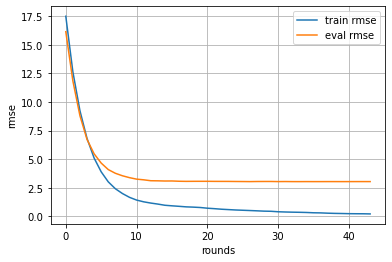

In [33]:
"""XGBoost で回帰するサンプルコード"""


def main():
    # Boston データセットを読み込む
    dataset = datasets.load_boston()
    X, y = dataset.data, dataset.target

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.3,
                                                        shuffle=True,
                                                        random_state=42,
                                                        )

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    xgb_params = {
        # 回帰問題
        'objective': 'reg:linear',
        # 学習用の指標 (RMSE)
        'eval_metric': 'rmse',
    }
    evals = [(dtrain, 'train'), (dtest, 'eval')]
    evals_result = {}
    bst = xgb.train(xgb_params,
                    dtrain,
                    num_boost_round=1000,
                    early_stopping_rounds=10,
                    evals=evals,
                    evals_result=evals_result,
                    )

    y_pred = bst.predict(dtest)
    mse = mean_squared_error(y_test, y_pred)
    print('RMSE:', math.sqrt(mse))

    train_metric = evals_result['train']['rmse']
    plt.plot(train_metric, label='train rmse')
    eval_metric = evals_result['eval']['rmse']
    plt.plot(eval_metric, label='eval rmse')
    plt.grid()
    plt.legend()
    plt.xlabel('rounds')
    plt.ylabel('rmse')
    plt.show()


if __name__ == '__main__':
    main()

## カスタムメトリックを扱う
これまでは XGBoost に組み込みで入っていた評価指標を用いて学習の進み具合を評価していた。    
続いては自分で書いたカスタムメトリックを使って学習してみる。
      
次のサンプルコードでは、再び乳がんデータセットを使った二値分類を扱っている。    
ただし、学習を評価するメトリックとして精度 (Accuracy) を計測するカスタムメトリックを使っている。    
カスタムメトリックを扱うにはオプションとして feval に自分で書いた関数を渡す。    
カスタムメトリックの関数は、評価指標の名前と値をタプルまたはリストで返すように作る。

[0]	train-logloss:0.46240	train-accuracy:0.05779	eval-logloss:0.49290	eval-accuracy:0.12865
[1]	train-logloss:0.33344	train-accuracy:0.03769	eval-logloss:0.37602	eval-accuracy:0.08187
[2]	train-logloss:0.24974	train-accuracy:0.02010	eval-logloss:0.30837	eval-accuracy:0.08772
[3]	train-logloss:0.19168	train-accuracy:0.01507	eval-logloss:0.26162	eval-accuracy:0.08187
[4]	train-logloss:0.15087	train-accuracy:0.01005	eval-logloss:0.22837	eval-accuracy:0.08187
[5]	train-logloss:0.12011	train-accuracy:0.00754	eval-logloss:0.20208	eval-accuracy:0.07018
[6]	train-logloss:0.09615	train-accuracy:0.00754	eval-logloss:0.17614	eval-accuracy:0.07018
[7]	train-logloss:0.07942	train-accuracy:0.00754	eval-logloss:0.16177	eval-accuracy:0.07018
[8]	train-logloss:0.06669	train-accuracy:0.00754	eval-logloss:0.15044	eval-accuracy:0.07018
[9]	train-logloss:0.05665	train-accuracy:0.00754	eval-logloss:0.14649	eval-accuracy:0.07018
[10]	train-logloss:0.04829	train-accuracy:0.00754	eval-logloss:0.13628	eval-accu

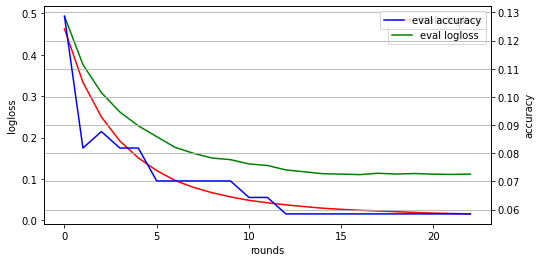

In [34]:
"""XGBoost で学習時にカスタムメトリックを使ったサンプルコード"""


def feval_accuracy(pred_proba, dtrain):
    """カスタムメトリックを計算する関数"""
    # 真のデータ
    y_true = dtrain.get_label().astype(int)
    # 予測
    y_pred = np.where(pred_proba > 0.5, 1, 0)
    # Accuracy を計算する
    acc = accuracy_score(y_true, y_pred)
    # メトリックの名前と数値を返す(最小化を目指すので 1 から引く)
    return 'accuracy', 1 - acc


def main():
    dataset = datasets.load_breast_cancer()
    X, y = dataset.data, dataset.target

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.3,
                                                        shuffle=True,
                                                        random_state=42,
                                                        stratify=y)

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    xgb_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
    }

    evals = [(dtrain, 'train'), (dtest, 'eval')]
    evals_result = {}
    bst = xgb.train(xgb_params,
                    dtrain,
                    num_boost_round=1000,
                    early_stopping_rounds=10,
                    evals=evals,
                    evals_result=evals_result,
                    # カスタマイズした評価関数を使う
                    feval=feval_accuracy,
                    )

    y_pred_proba = bst.predict(dtest)
    y_pred = np.where(y_pred_proba > 0.5, 1, 0)
    acc = accuracy_score(y_test, y_pred)
    print('Accuracy:', acc)

    # デフォルトのメトリック
    _, ax1 = plt.subplots(figsize=(8, 4))
    train_metric = evals_result['train']['logloss']
    ax1.plot(train_metric, label='train logloss', c='r')
    eval_metric = evals_result['eval']['logloss']
    ax1.plot(eval_metric, label='eval logloss', c='g')
    ax1.set_ylabel('logloss')
    ax1.legend()
    ax1.set_xlabel('rounds')

    # カスタムメトリック
    ax2 = ax1.twinx()
    eval_custom_metric = evals_result['eval']['accuracy']
    ax2.plot(eval_custom_metric, label='eval accuracy', c='b')
    ax2.set_ylabel('accuracy')
    ax2.legend()

    plt.grid()
    plt.show()


if __name__ == '__main__':
    main()

## 組み込みの交差検証の機能
XGBoost には、組み込みの交差検証 (Cross Validation) の機能がある。   
そんなに使いやすいものではないらしい。   
機能は xgboost.cv() という関数が起点になる。    
基本的なパラメータについては xgboost.train() で普通に学習するときとさほど変わらない。    
関数から最終的に得られるのは、学習過程におけるメトリックの値の変化。

[0]	train-logloss:0.46191+0.00201	test-logloss:0.48262+0.01761
[1]	train-logloss:0.33019+0.00133	test-logloss:0.36473+0.02390
[2]	train-logloss:0.24479+0.00177	test-logloss:0.29025+0.03124
[3]	train-logloss:0.18546+0.00180	test-logloss:0.23864+0.03532
[4]	train-logloss:0.14318+0.00183	test-logloss:0.20102+0.03969
[5]	train-logloss:0.11288+0.00169	test-logloss:0.17490+0.03912
[6]	train-logloss:0.09082+0.00141	test-logloss:0.15802+0.04489
[7]	train-logloss:0.07417+0.00159	test-logloss:0.14257+0.04424
[8]	train-logloss:0.06181+0.00160	test-logloss:0.13379+0.04676
[9]	train-logloss:0.05210+0.00148	test-logloss:0.12532+0.04805
[10]	train-logloss:0.04419+0.00147	test-logloss:0.11680+0.04772
[11]	train-logloss:0.03785+0.00146	test-logloss:0.11072+0.04839
[12]	train-logloss:0.03287+0.00125	test-logloss:0.10662+0.04719
[13]	train-logloss:0.02892+0.00100	test-logloss:0.10493+0.04944
[14]	train-logloss:0.02590+0.00101	test-logloss:0.10352+0.05133
[15]	train-logloss:0.02328+0.00090	test-logloss:0.

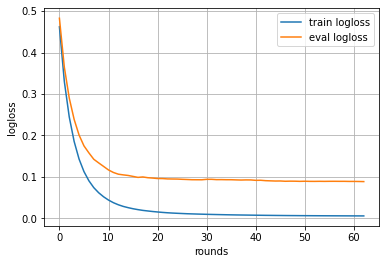

In [35]:
"""XGBoost 組み込みの交差検証を使ったサンプルコード"""

def main():
    dataset = datasets.load_breast_cancer()
    X, y = dataset.data, dataset.target

    # CV の中で分割するので丸ごと渡す
    dtrain = xgb.DMatrix(X, label=y)

    xgb_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
    }

    # 交差検証する
    history = xgb.cv(xgb_params,
                     dtrain,
                     num_boost_round=1000,
                     early_stopping_rounds=10,
                     nfold=10,
                     # 層化分割する
                     stratified=True,
                     # 検証の経過を出力する
                     verbose_eval=True,
                     )

    train_metric = history['train-logloss-mean']
    plt.plot(train_metric, label='train logloss')
    eval_metric = history['test-logloss-mean']
    plt.plot(eval_metric, label='eval logloss')
    plt.grid()
    plt.legend()
    plt.xlabel('rounds')
    plt.ylabel('logloss')
    plt.show()


if __name__ == '__main__':
    main()

# 本番
本番というかfrank datasetを使用して実施してみる

## データの読み込み

In [8]:
# 必要なパッケージ
import glob
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

In [19]:
# データの読み込み
df_ori =  pd.read_csv("featMat.csv", sep=',', header=None)
df = df_ori.copy()
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,37,4,0.341,0.256,27.416,-27.113,12.3980,-32.960,16.1160,0.35736,4,-2.770400,1,0.41784,4.1784,2719.20,-604180.0,-432.24,603320.0,4.1784,0.17777,0.000000,0.00000,0.124440,-2.581200,16.1320,0.99898,63.018,-432.24,0.32,0.044444,0.0,0,1
1,37,4,0.913,0.086,21.771,-30.037,9.8778,-33.867,12.4950,0.26504,4,-2.830000,1,0.00000,156.7900,502.37,-26083.0,5117.70,116600.0,265.1400,0.78867,0.000000,0.00000,0.406210,-2.199400,12.5960,0.99197,146.470,5117.70,0.60,0.088889,0.0,0,1
2,37,4,0.733,0.111,10.886,-34.169,26.9120,-34.673,16.0340,0.99118,2,-0.031436,1,32.12200,143.8500,263.58,-52140.0,-3563.50,26382.0,188.8200,-1.06510,-0.802530,-0.11658,0.000000,0.086288,16.2030,0.98959,145.970,-3563.50,0.48,0.044444,0.0,0,1
3,37,4,0.448,0.094,19.151,-34.572,12.7000,-36.790,6.8213,0.59647,4,-2.810500,1,17.36000,76.6380,230.62,-10012.0,-4604.10,25874.0,95.8570,0.60170,0.000000,0.10128,0.570430,-2.723100,6.9674,0.97902,74.122,-4604.10,0.40,0.044444,0.0,0,1
4,37,4,0.519,0.056,27.718,-32.758,14.6150,-37.294,13.8660,0.67819,4,-2.808300,1,74.82100,275.5700,993.21,-126180.0,-21377.00,217040.0,244.6800,-0.10990,-0.096714,0.00000,0.001099,-2.717000,13.8710,0.99965,247.690,-21377.00,0.44,0.044444,0.0,0,1


In [20]:
# 34 columns name update
df.columns = ['user', 'doc', 'stroke_inter', 'stroke_duration', 'start_x', 'start_y', 'stop_x', 'stop_y', 
              'direct_ete_distance', 'mean_result_leng', 'flag', 'direct_ete_line', 'phone', '20_pairwise_v', 
              '50_pairwise_v', '80_pairwise_v', '20_pairwise_acc', '50_pairwise_acc', '80_pairwise_acc', '3ots_m_v', 
              'ete_larg_deviation', '20_ete_line', '50_ete_line', '80_ete_line', 'ave_direction', 'length_trajectory', 
              'ratio_ete', 'ave_v', '5points_m_acc', 'm_stroke_press', 'm_stroke_area_cover', 'finger_orien',
              'cd_finger_orien', 'phone_orien' ]
df.head()

,user,doc,stroke_inter,stroke_duration,start_x,start_y,stop_x,stop_y,direct_ete_distance,mean_result_leng,flag,direct_ete_line,phone,20_pairwise_v,50_pairwise_v,80_pairwise_v,20_pairwise_acc,50_pairwise_acc,80_pairwise_acc,3ots_m_v,ete_larg_deviation,20_ete_line,50_ete_line,80_ete_line,ave_direction,length_trajectory,ratio_ete,ave_v,5points_m_acc,m_stroke_press,m_stroke_area_cover,finger_orien,cd_finger_orien,phone_orien
0,37,4,0.341,0.256,27.416,-27.113,12.3980,-32.960,16.1160,0.35736,4,-2.770400,1,0.41784,4.1784,2719.20,-604180.0,-432.24,603320.0,4.1784,0.17777,0.000000,0.00000,0.124440,-2.581200,16.1320,0.99898,63.018,-432.24,0.32,0.044444,0.0,0,1
1,37,4,0.913,0.086,21.771,-30.037,9.8778,-33.867,12.4950,0.26504,4,-2.830000,1,0.00000,156.7900,502.37,-26083.0,5117.70,116600.0,265.1400,0.78867,0.000000,0.00000,0.406210,-2.199400,12.5960,0.99197,146.470,5117.70,0.60,0.088889,0.0,0,1
2,37,4,0.733,0.111,10.886,-34.169,26.9120,-34.673,16.0340,0.99118,2,-0.031436,1,32.12200,143.8500,263.58,-52140.0,-3563.50,26382.0,188.8200,-1.06510,-0.802530,-0.11658,0.000000,0.086288,16.2030,0.98959,145.970,-3563.50,0.48,0.044444,0.0,0,1
3,37,4,0.448,0.094,19.151,-34.572,12.7000,-36.790,6.8213,0.59647,4,-2.810500,1,17.36000,76.6380,230.62,-10012.0,-4604.10,25874.0,95.8570,0.60170,0.000000,0.10128,0.570430,-2.723100,6.9674,0.97902,74.122,-4604.10,0.40,0.044444,0.0,0,1
4,37,4,0.519,0.056,27.718,-32.758,14.6150,-37.294,13.8660,0.67819,4,-2.808300,1,74.82100,275.5700,993.21,-126180.0,-21377.00,217040.0,244.6800,-0.10990,-0.096714,0.00000,0.001099,-2.717000,13.8710,0.99965,247.690,-21377.00,0.44,0.044444,0.0,0,1


In [21]:
df.columns

Index(['user', 'doc', 'stroke_inter', 'stroke_duration', 'start_x', 'start_y',
       'stop_x', 'stop_y', 'direct_ete_distance', 'mean_result_leng', 'flag',
       'direct_ete_line', 'phone', '20_pairwise_v', '50_pairwise_v',
       '80_pairwise_v', '20_pairwise_acc', '50_pairwise_acc',
       '80_pairwise_acc', '3ots_m_v', 'ete_larg_deviation', '20_ete_line',
       '50_ete_line', '80_ete_line', 'ave_direction', 'length_trajectory',
       'ratio_ete', 'ave_v', '5points_m_acc', 'm_stroke_press',
       'm_stroke_area_cover', 'finger_orien', 'cd_finger_orien',
       'phone_orien'],
      dtype='object')

### 文献[1]と自分が使用している名称の対応表

|番号|自分|文献[1]|
|-----|:----|:----|
|1|'user'|| 
|2|'doc'|document ID| 
|3|'stroke_inter'|time strokes|
|4|'stroke_duration'|time span stroke|
|5|'start_x'|beginning of x|
|6|'start_y'|beginning of y|
|7|'stop_x'|ending of x|
|8|'stop_y'|ending of y|
|9|'direct_ete_distance'|directional distance|
|10|'mean_result_leng'|average distance|
|11|'flag'|directional flags|
|12|'direct_ete_line'|directional stroke|
|13|'phone'|-|
|14|'20_pairwise_v'|1/5 velocity|
|15|'50_pairwise_v'|1/2 velocity|
|16|'80_pairwise_v'|4/5 velocity|
|17|'20_pairwise_acc'|1/5 acceleration|
|18|'50_pairwise_acc'|1/2 acceleration|
|19|'80_pairwise_acc'|4/5 acceleration|
|20|'3ots_m_v'|Final median stroke speed at 3 pts|
|21|'ete_larg_deviation'|stroke deviation|
|22|'20_ete_line'|1/5 deviation|
|23|'50_ete_line'|1/2 deviation|
|24|'80_ete_line'|4/5 deviation|
|25|'ave_direction'|mean direction|
|26|'length_trajectory'|length of trajectory|
|27|'ratio_ete'|length trajectory ratio|
|28|'ave_v'|mean velocity|
|29|'5points_m_acc'|average acceleration|
|30|'m_stroke_press'|pressure|
|31|'m_stroke_area_cover'|area covered|
|32|'finger_orien'|-|
|33|'cd_finger_orien'|-|
|34|'phone_orien'|phone orientation|

In [22]:
# 欠損値確認
df.isnull().sum()

user                     0
doc                      0
stroke_inter            39
stroke_duration          0
start_x                  0
start_y                  0
stop_x                   0
stop_y                   0
direct_ete_distance      0
mean_result_leng         0
flag                     0
direct_ete_line          0
phone                    0
20_pairwise_v            0
50_pairwise_v            0
80_pairwise_v            0
20_pairwise_acc        263
50_pairwise_acc        259
80_pairwise_acc        256
3ots_m_v                 1
ete_larg_deviation       0
20_ete_line              0
50_ete_line              0
80_ete_line              0
ave_direction            0
length_trajectory        0
ratio_ete              262
ave_v                    0
5points_m_acc          257
m_stroke_press           0
m_stroke_area_cover      0
finger_orien             0
cd_finger_orien          0
phone_orien              0
dtype: int64

In [24]:
# 欠損値削除
df_dropna = df.dropna(axis=0, how='any')
df_dropna.isnull().sum()

user                   0
doc                    0
stroke_inter           0
stroke_duration        0
start_x                0
start_y                0
stop_x                 0
stop_y                 0
direct_ete_distance    0
mean_result_leng       0
flag                   0
direct_ete_line        0
phone                  0
20_pairwise_v          0
50_pairwise_v          0
80_pairwise_v          0
20_pairwise_acc        0
50_pairwise_acc        0
80_pairwise_acc        0
3ots_m_v               0
ete_larg_deviation     0
20_ete_line            0
50_ete_line            0
80_ete_line            0
ave_direction          0
length_trajectory      0
ratio_ete              0
ave_v                  0
5points_m_acc          0
m_stroke_press         0
m_stroke_area_cover    0
finger_orien           0
cd_finger_orien        0
phone_orien            0
dtype: int64

In [25]:
df_dropna.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20848 entries, 0 to 21157
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user                 20848 non-null  int64  
 1   doc                  20848 non-null  int64  
 2   stroke_inter         20848 non-null  float64
 3   stroke_duration      20848 non-null  float64
 4   start_x              20848 non-null  float64
 5   start_y              20848 non-null  float64
 6   stop_x               20848 non-null  float64
 7   stop_y               20848 non-null  float64
 8   direct_ete_distance  20848 non-null  float64
 9   mean_result_leng     20848 non-null  float64
 10  flag                 20848 non-null  int64  
 11  direct_ete_line      20848 non-null  float64
 12  phone                20848 non-null  int64  
 13  20_pairwise_v        20848 non-null  float64
 14  50_pairwise_v        20848 non-null  float64
 15  80_pairwise_v        20848 non-null 

In [31]:
df_dropna.shape

(20848, 34)

In [55]:
# userごとのデータ数
pd.DataFrame(df_dropna['user'].value_counts()).sort_index(ascending=True, axis=1)

,user
2,1213
35,1061
23,938
38,779
3,757
17,705
21,700
28,697
33,684
15,670


ひとまずデータの準備は終了

## 問題点1について

### 文献[1]との結果の差をみるため同じ条件で実施

In [125]:
df_dropna1 = df_dropna.copy()
# 使用しない列の削除
df_drop1 = df_dropna1.drop({'phone', 'finger_orien', 'cd_finger_orien'}, axis=1)
df_drop1.shape
# df_drop.isnull().sum()

(20848, 31)

In [37]:
# df_drop1.columns

手順
1. 2値分類で実行

[0]	train-logloss:0.44564	eval-logloss:0.44415
[1]	train-logloss:0.30995	eval-logloss:0.30812
[2]	train-logloss:0.22064	eval-logloss:0.21749
[3]	train-logloss:0.16086	eval-logloss:0.15674
[4]	train-logloss:0.11957	eval-logloss:0.11439
[5]	train-logloss:0.09032	eval-logloss:0.08498
[6]	train-logloss:0.06906	eval-logloss:0.06342
[7]	train-logloss:0.05350	eval-logloss:0.04758
[8]	train-logloss:0.04178	eval-logloss:0.03633
[9]	train-logloss:0.03302	eval-logloss:0.02774
[10]	train-logloss:0.02652	eval-logloss:0.02140
[11]	train-logloss:0.02166	eval-logloss:0.01723
[12]	train-logloss:0.01818	eval-logloss:0.01371
[13]	train-logloss:0.01535	eval-logloss:0.01121
[14]	train-logloss:0.01329	eval-logloss:0.00959
[15]	train-logloss:0.01131	eval-logloss:0.00823
[16]	train-logloss:0.00993	eval-logloss:0.00696
[17]	train-logloss:0.00893	eval-logloss:0.00615
[18]	train-logloss:0.00775	eval-logloss:0.00529
[19]	train-logloss:0.00679	eval-logloss:0.00465
[20]	train-logloss:0.00622	eval-logloss:0.00418
[2

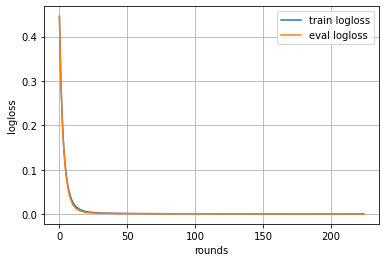

In [130]:
# 二値分類
def main3_2_1(df):
    
    a = 2
    b = 35
    df_select = df[df['user'].isin((a,b))].replace({a: 0, b: 1})
    
    
    # 教師データの作成
    y = df_select.user
    X = df_select.drop("user", 1)

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=2021,
                                                        stratify=y)

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    xgb_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
    }

    # 学習時に用いる検証用データ
    evals = [(dtrain, 'train'), (dtest, 'eval')]
    # 学習過程を記録するための辞書
    evals_result = {}
    bst = xgb.train(xgb_params,
                    dtrain,
                    num_boost_round=1000,  # ラウンド数を増やしておく
                    early_stopping_rounds=10,
                    evals=evals,
                    evals_result=evals_result,
                    )

    y_pred_proba = bst.predict(dtest)
    y_pred = np.where(y_pred_proba > 0.5, 1, 0)
    acc = accuracy_score(y_test, y_pred)
    print('Accuracy:', acc)

    # 学習の課程を折れ線グラフとしてプロットする
    train_metric = evals_result['train']['logloss']
    plt.plot(train_metric, label='train logloss')
    eval_metric = evals_result['eval']['logloss']
    plt.plot(eval_metric, label='eval logloss')
    plt.grid()
    plt.legend()
    plt.xlabel('rounds')
    plt.ylabel('logloss')
    plt.show()

    return X_train, X_test, y_train, y_test
if __name__ == '__main__':
    X_train, X_test, y_train, y_test = main3_2_1(df_drop1)

In [131]:
X_train.shape

(1819, 30)

In [132]:
X_test.shape

(455, 30)

In [66]:
# trainとtestの比率が同じか確認
import collections

In [133]:
collections.Counter(y_train)

Counter({0: 970, 1: 849})

In [134]:
collections.Counter(y_test)

Counter({0: 243, 1: 212})

Counter({1: 970, 34: 849, 22: 750, 37: 623, 2: 606, 16: 564, 20: 560, 27: 558, 32: 547, 14: 536, 13: 518, 7: 492, 26: 486, 33: 486, 6: 467, 5: 448, 35: 394, 17: 367, 8: 361, 10: 355, 28: 344, 23: 343, 38: 343, 36: 338, 4: 329, 24: 328, 9: 308, 15: 304, 0: 304, 21: 295, 30: 294, 19: 283, 11: 273, 39: 248, 12: 244, 31: 242, 18: 234, 25: 182, 3: 181, 29: 178, 40: 146})
[0]	train-mlogloss:1.91285	eval-mlogloss:2.17111
[1]	train-mlogloss:1.53646	eval-mlogloss:1.85153
[2]	train-mlogloss:1.31642	eval-mlogloss:1.66771
[3]	train-mlogloss:1.15054	eval-mlogloss:1.52699
[4]	train-mlogloss:1.02506	eval-mlogloss:1.42072
[5]	train-mlogloss:0.92113	eval-mlogloss:1.33646
[6]	train-mlogloss:0.83076	eval-mlogloss:1.26187
[7]	train-mlogloss:0.75634	eval-mlogloss:1.20272
[8]	train-mlogloss:0.69203	eval-mlogloss:1.15217
[9]	train-mlogloss:0.63692	eval-mlogloss:1.10733
[10]	train-mlogloss:0.59297	eval-mlogloss:1.07403
[11]	train-mlogloss:0.54876	eval-mlogloss:1.04088
[12]	train-mlogloss:0.51010	eval-mlogloss

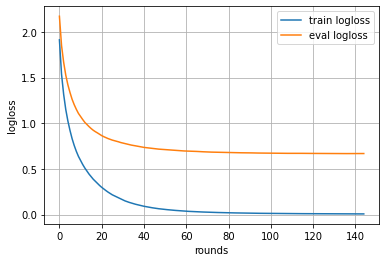

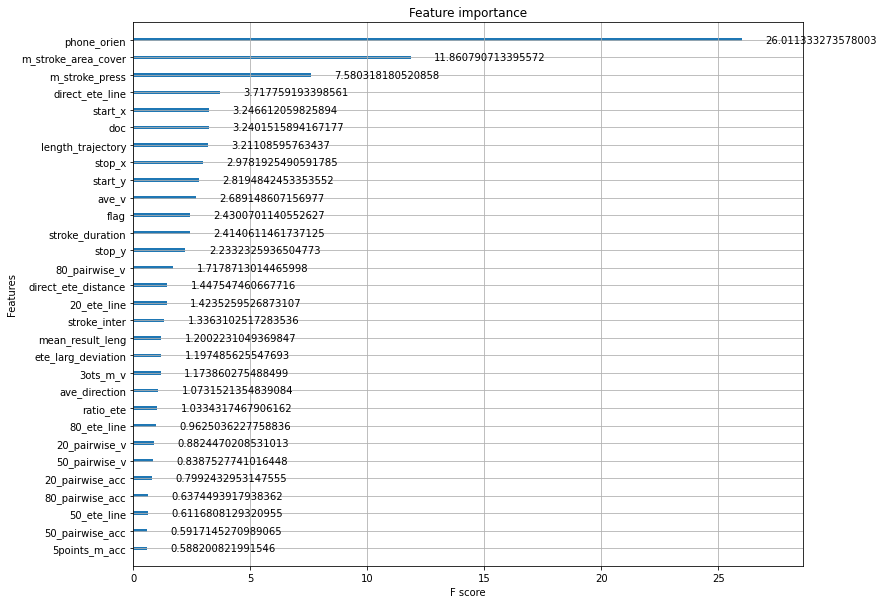

In [136]:
# 多クラス分類
def main3_2_1_m(df1):
    
    df = df1.copy()
    
#     a, b, c, d, e = 2, 35, 23, 38, 3
#     df_select = df[df['user'].isin((a, b, c, d, e))].replace({a: 0, b: 1, c: 2, d: 3, e: 4})
    
#     # 教師データの作成
#     y = df_select.user
#     X = df_select.drop("user", 1)

    df2 = df1.copy()
    df2["user"] = df2["user"]-1
    # 教師データの作成
    y = df2.user
    X = df2.drop("user", 1)

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=2021,
                                                        stratify=y)

#     dtrain = xgb.DMatrix(X_train, label=y_train)
#     dtest = xgb.DMatrix(X_test, label=y_test)
    
    # 可視化のために特徴量の名前を渡しておく
    dtrain = xgb.DMatrix(X_train, label=y_train,
                         feature_names=df.columns[1:])
    dtest = xgb.DMatrix(X_test, label=y_test,
                        feature_names=df.columns[1:])

    print(collections.Counter(y_train))
    
    eval_metric = 'mlogloss'
    
    xgb_params = {
        # 多値分類問題
        'objective': 'multi:softmax',
        # クラス数
        'num_class': 41,
        # 学習用の指標 (Multiclass logloss)
        'eval_metric': eval_metric,
    }

    # 学習時に用いる検証用データ
    evals = [(dtrain, 'train'), (dtest, 'eval')]
    # 学習過程を記録するための辞書
    evals_result = {}
    bst = xgb.train(xgb_params,
                    dtrain,
                    num_boost_round=1000,  # ラウンド数を増やしておく
                    early_stopping_rounds=10,
                    evals=evals,
                    evals_result=evals_result,
                    )

    y_pred = bst.predict(dtest)
    acc = accuracy_score(y_test, y_pred)
    print('Accuracy:', acc)

    # 学習の課程を折れ線グラフとしてプロットする
    train_metric = evals_result['train'][eval_metric]
    plt.plot(train_metric, label='train logloss')
    eval_metric = evals_result['eval'][eval_metric]
    plt.plot(eval_metric, label='eval logloss')
    plt.grid()
    plt.legend()
    plt.xlabel('rounds')
    plt.ylabel('logloss')
    plt.show()
    
    
    def plot2(bst):
        # 性能向上に寄与する度合いで重要度をプロットする
        _, ax = plt.subplots(figsize=(12, 10))
        xgb.plot_importance(bst,
                            ax=ax,
                            importance_type='gain',
                            show_values=True)
        plt.show()
    
    plot2(bst)

    return X_train, X_test, y_train, y_test
if __name__ == '__main__':
    X_train, X_test, y_train, y_test = main3_2_1_m(df_drop1)

#### 結果

Counter({0: 970, 1: 849, 2: 750, 3: 623, 4: 606})
[0]	train-mlogloss:1.08878	eval-mlogloss:1.10865
[1]	train-mlogloss:0.81223	eval-mlogloss:0.85017
[2]	train-mlogloss:0.62442	eval-mlogloss:0.67257
[3]	train-mlogloss:0.48690	eval-mlogloss:0.54276
[4]	train-mlogloss:0.38812	eval-mlogloss:0.45345
[5]	train-mlogloss:0.31547	eval-mlogloss:0.38537
[6]	train-mlogloss:0.26094	eval-mlogloss:0.33689
[7]	train-mlogloss:0.21637	eval-mlogloss:0.29943
[8]	train-mlogloss:0.17915	eval-mlogloss:0.26500
[9]	train-mlogloss:0.15345	eval-mlogloss:0.24273
[10]	train-mlogloss:0.13431	eval-mlogloss:0.22470
[11]	train-mlogloss:0.11918	eval-mlogloss:0.21055
[12]	train-mlogloss:0.10505	eval-mlogloss:0.19854
[13]	train-mlogloss:0.09279	eval-mlogloss:0.18745
[14]	train-mlogloss:0.08274	eval-mlogloss:0.17767
[15]	train-mlogloss:0.07395	eval-mlogloss:0.16990
[16]	train-mlogloss:0.06636	eval-mlogloss:0.16325
[17]	train-mlogloss:0.05883	eval-mlogloss:0.15650
[18]	train-mlogloss:0.05346	eval-mlogloss:0.15261
[19]	train

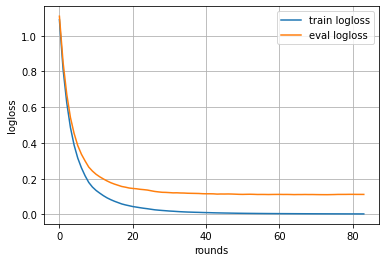

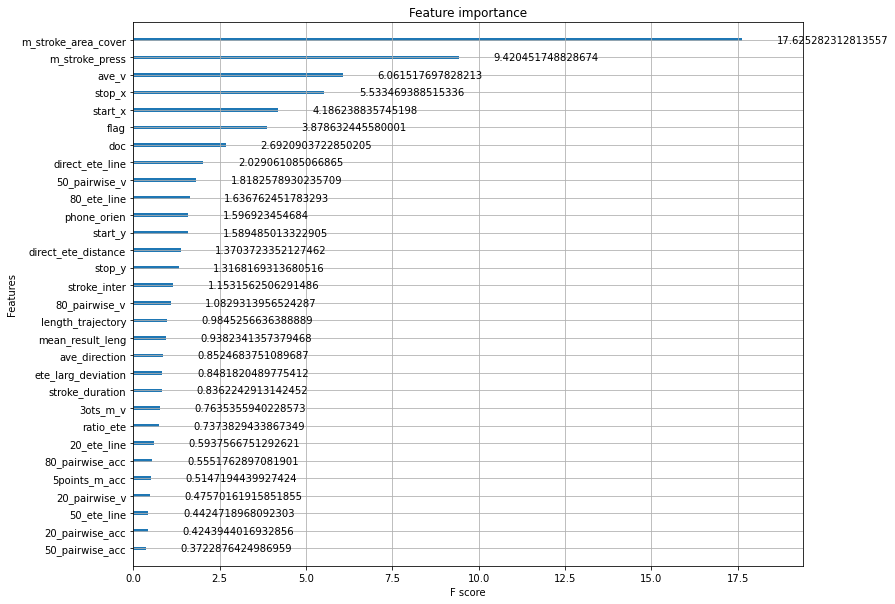

In [137]:
# 多クラス分類
def main3_2_1_m2(df1):
    
    df = df1.copy()
    
    a, b, c, d, e = 2, 35, 23, 38, 3
    df_select = df[df['user'].isin((a, b, c, d, e))].replace({a: 0, b: 1, c: 2, d: 3, e: 4})
    
    # 教師データの作成
    y = df_select.user
    X = df_select.drop("user", 1)

#     df2 = df1.copy()
#     df2["user"] = df2["user"]-1
#     # 教師データの作成
#     y = df2.user
#     X = df2.drop("user", 1)

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=2021,
                                                        stratify=y)

#     dtrain = xgb.DMatrix(X_train, label=y_train)
#     dtest = xgb.DMatrix(X_test, label=y_test)
    
    # 可視化のために特徴量の名前を渡しておく
    dtrain = xgb.DMatrix(X_train, label=y_train,
                         feature_names=df.columns[1:])
    dtest = xgb.DMatrix(X_test, label=y_test,
                        feature_names=df.columns[1:])

    print(collections.Counter(y_train))
    
    eval_metric = 'mlogloss'
    
    xgb_params = {
        # 多値分類問題
        'objective': 'multi:softmax',
        # クラス数
        'num_class': 5,
        # 学習用の指標 (Multiclass logloss)
        'eval_metric': eval_metric,
    }

    # 学習時に用いる検証用データ
    evals = [(dtrain, 'train'), (dtest, 'eval')]
    # 学習過程を記録するための辞書
    evals_result = {}
    bst = xgb.train(xgb_params,
                    dtrain,
                    num_boost_round=1000,  # ラウンド数を増やしておく
                    early_stopping_rounds=10,
                    evals=evals,
                    evals_result=evals_result,
                    )

    y_pred = bst.predict(dtest)
    acc = accuracy_score(y_test, y_pred)
    print('Accuracy:', acc)

    # 学習の課程を折れ線グラフとしてプロットする
    train_metric = evals_result['train'][eval_metric]
    plt.plot(train_metric, label='train logloss')
    eval_metric = evals_result['eval'][eval_metric]
    plt.plot(eval_metric, label='eval logloss')
    plt.grid()
    plt.legend()
    plt.xlabel('rounds')
    plt.ylabel('logloss')
    plt.show()
    
    
    def plot2(bst):
        # 性能向上に寄与する度合いで重要度をプロットする
        _, ax = plt.subplots(figsize=(12, 10))
        xgb.plot_importance(bst,
                            ax=ax,
                            importance_type='gain',
                            show_values=True)
        plt.show()
    
    plot2(bst)

    return X_train, X_test, y_train, y_test
if __name__ == '__main__':
    X_train, X_test, y_train, y_test = main3_2_1_m2(df_drop1)

Counter({0: 970, 1: 849, 2: 750, 3: 623, 4: 606})
[0]	train-mlogloss:1.08878	eval-mlogloss:1.10865
[10]	train-mlogloss:0.13431	eval-mlogloss:0.22470
[20]	train-mlogloss:0.04433	eval-mlogloss:0.14552
[30]	train-mlogloss:0.01920	eval-mlogloss:0.12224
[40]	train-mlogloss:0.01042	eval-mlogloss:0.11562
[50]	train-mlogloss:0.00645	eval-mlogloss:0.11230
[60]	train-mlogloss:0.00471	eval-mlogloss:0.11226
[70]	train-mlogloss:0.00378	eval-mlogloss:0.11120
[80]	train-mlogloss:0.00320	eval-mlogloss:0.11255
[83]	train-mlogloss:0.00308	eval-mlogloss:0.11214

Accuracy: 0.9547368421052631
nfold: 5


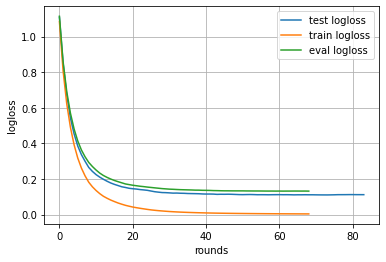

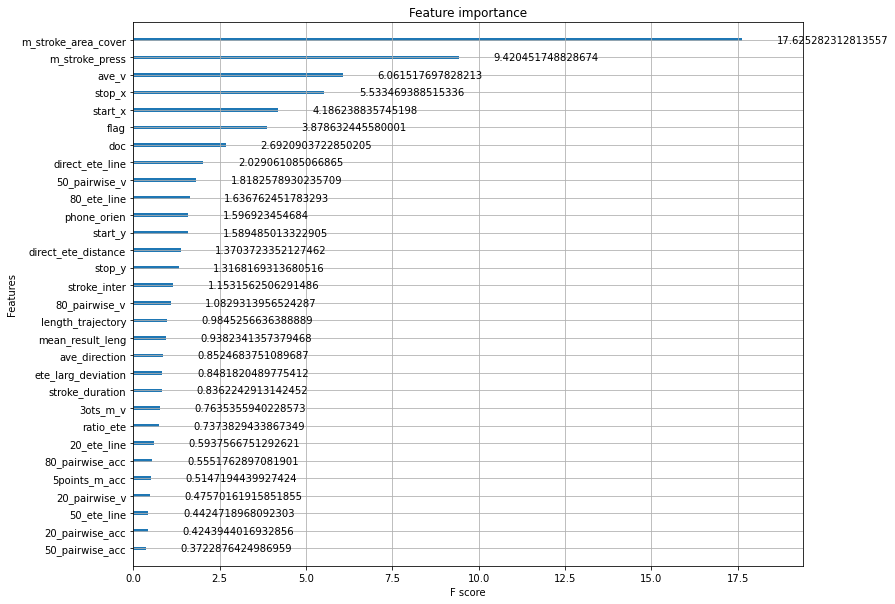

In [195]:
# 多クラス分類
def main3_2_1_m3(df1, nfold):
    
    df = df1.copy()
    
    a, b, c, d, e = 2, 35, 23, 38, 3
    df_select = df[df['user'].isin((a, b, c, d, e))].replace({a: 0, b: 1, c: 2, d: 3, e: 4})
    
    # 教師データの作成
    y = df_select.user
    X = df_select.drop("user", 1)

#     df2 = df1.copy()
#     df2["user"] = df2["user"]-1
#     # 教師データの作成
#     y = df2.user
#     X = df2.drop("user", 1)

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=2021,
                                                        stratify=y)

#     dtrain = xgb.DMatrix(X_train, label=y_train)
#     dtest = xgb.DMatrix(X_test, label=y_test)
    
    # 可視化のために特徴量の名前を渡しておく
    dtrain = xgb.DMatrix(X_train, label=y_train,
                         feature_names=df.columns[1:], silent=1)
    dtest = xgb.DMatrix(X_test, label=y_test,
                        feature_names=df.columns[1:], silent=1)

    print(collections.Counter(y_train))
    
    eval_metric = 'mlogloss'
    
    xgb_params = {
        # 多値分類問題
        'objective': 'multi:softmax',
        # クラス数
        'num_class': 5,
        # 学習用の指標 (Multiclass logloss)
        'eval_metric': eval_metric,
#         'learning_rate': 0.1,
    }
    
    
    # 交差検証する
    history = xgb.cv(xgb_params,
                     dtrain,
                     num_boost_round=1000,
                     early_stopping_rounds=10,
                     nfold=nfold,
                     # 層化分割する
                     stratified=True,
                     # 検証の経過を出力する
                     verbose_eval=10,
                     )
    
    # 学習時に用いる検証用データ
    evals = [(dtrain, 'train'), (dtest, 'eval')]
    # 学習過程を記録するための辞書
    evals_result = {}
    bst = xgb.train(xgb_params,
                    dtrain,
                    num_boost_round=1000,  # ラウンド数を増やしておく
                    early_stopping_rounds=10,
                    evals=evals,
                    evals_result=evals_result,
                    verbose_eval=10,
                    )

    y_pred = bst.predict(dtest)
    acc = accuracy_score(y_test, y_pred)
    print('\nAccuracy:', acc)
    
#     df_accuracy = pd.DataFrame({'va_y': y_test,
#                             'y_pred_max': y_pred_max})
#     pd.crosstab(df_accuracy['va_y'], df_accuracy['y_pred_max'])
    
    print(f'nfold: {nfold}')
    # 学習の課程を折れ線グラフとしてプロットする
#     train_metric = evals_result['train'][eval_metric]
#     plt.plot(train_metric, label='train logloss')
    test_metric = evals_result['eval'][eval_metric]
    plt.plot(test_metric, label='test logloss')
    train_metric = history['train-mlogloss-mean']
    plt.plot(train_metric, label='train logloss')
    eval_metric = history['test-mlogloss-mean']
    plt.plot(eval_metric, label='eval logloss')
    plt.grid()
    plt.legend()
    plt.xlabel('rounds')
    plt.ylabel('logloss')
    plt.show()
    
    
    def plot2(bst):
        # 性能向上に寄与する度合いで重要度をプロットする
        _, ax = plt.subplots(figsize=(12, 10))
        xgb.plot_importance(bst,
                            ax=ax,
                            importance_type='gain',
                            show_values=True)
        plt.show()
    
    plot2(bst)

    return X_train, X_test, y_train, y_test
if __name__ == '__main__':
    X_train, X_test, y_train, y_test = main3_2_1_m3(df_drop1, nfold=5)

Counter({0: 970, 1: 849, 2: 750, 3: 623, 4: 606})
[0]	train-mlogloss:1.08878	eval-mlogloss:1.10865
[10]	train-mlogloss:0.13431	eval-mlogloss:0.22470
[20]	train-mlogloss:0.04433	eval-mlogloss:0.14552
[30]	train-mlogloss:0.01920	eval-mlogloss:0.12224
[40]	train-mlogloss:0.01042	eval-mlogloss:0.11562
[50]	train-mlogloss:0.00645	eval-mlogloss:0.11230
[60]	train-mlogloss:0.00471	eval-mlogloss:0.11226
[70]	train-mlogloss:0.00378	eval-mlogloss:0.11120
[80]	train-mlogloss:0.00320	eval-mlogloss:0.11255
[83]	train-mlogloss:0.00308	eval-mlogloss:0.11214

Accuracy: 0.9547368421052631
nfold: 10


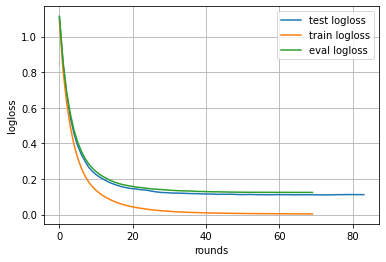

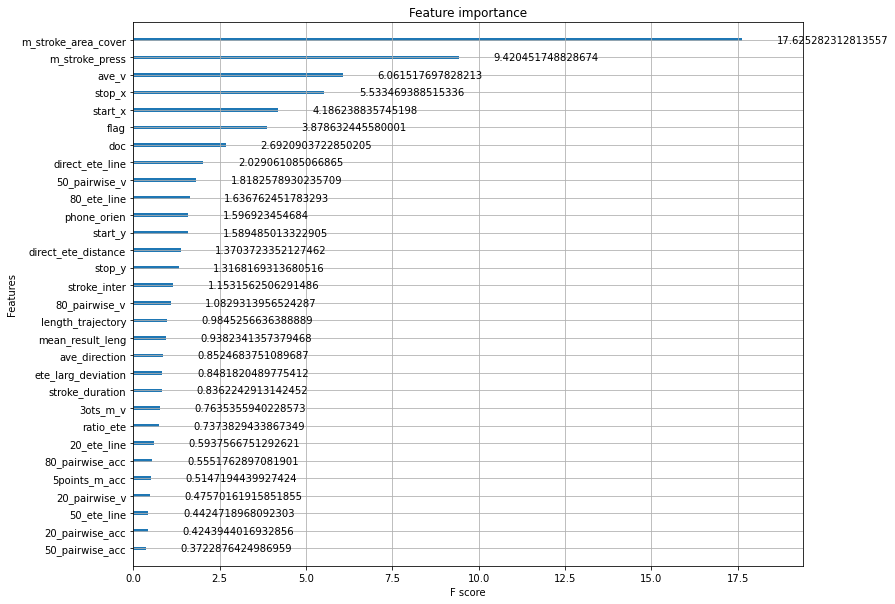

In [196]:
X_train, X_test, y_train, y_test = main3_2_1_m3(df_drop1, nfold=10)

Counter({0: 970, 1: 849, 2: 750, 3: 623, 4: 606})
[0]	train-mlogloss:1.08878	eval-mlogloss:1.10865
[10]	train-mlogloss:0.13431	eval-mlogloss:0.22470
[20]	train-mlogloss:0.04433	eval-mlogloss:0.14552
[30]	train-mlogloss:0.01920	eval-mlogloss:0.12224
[40]	train-mlogloss:0.01042	eval-mlogloss:0.11562
[50]	train-mlogloss:0.00645	eval-mlogloss:0.11230
[60]	train-mlogloss:0.00471	eval-mlogloss:0.11226
[70]	train-mlogloss:0.00378	eval-mlogloss:0.11120
[80]	train-mlogloss:0.00320	eval-mlogloss:0.11255
[83]	train-mlogloss:0.00308	eval-mlogloss:0.11214

Accuracy: 0.9547368421052631
nfold: 3


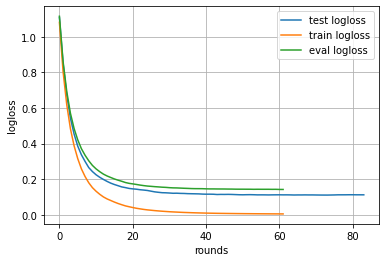

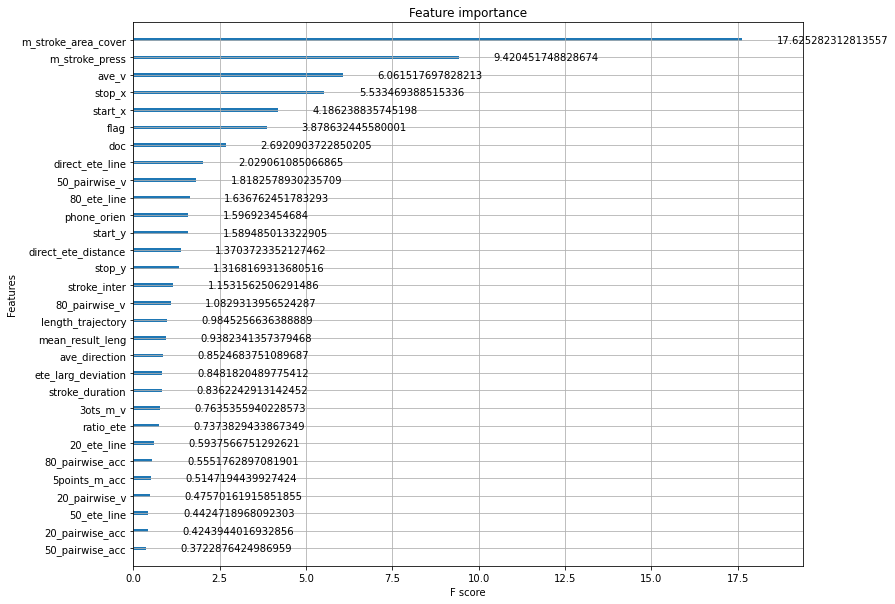

In [197]:
X_train, X_test, y_train, y_test = main3_2_1_m3(df_drop1, nfold=3)

#### 41人_文献1に即した結果

Counter({1: 970, 34: 849, 22: 750, 37: 623, 2: 606, 16: 564, 20: 560, 27: 558, 32: 547, 14: 536, 13: 518, 7: 492, 26: 486, 33: 486, 6: 467, 5: 448, 35: 394, 17: 367, 8: 361, 10: 355, 28: 344, 23: 343, 38: 343, 36: 338, 4: 329, 24: 328, 9: 308, 15: 304, 0: 304, 21: 295, 30: 294, 19: 283, 11: 273, 39: 248, 12: 244, 31: 242, 18: 234, 25: 182, 3: 181, 29: 178, 40: 146})
[0]	train-mlogloss:1.91285	eval-mlogloss:2.17111
[10]	train-mlogloss:0.59297	eval-mlogloss:1.07403
[20]	train-mlogloss:0.29812	eval-mlogloss:0.86437
[30]	train-mlogloss:0.16024	eval-mlogloss:0.78291
[40]	train-mlogloss:0.09068	eval-mlogloss:0.73526
[50]	train-mlogloss:0.05598	eval-mlogloss:0.71059
[60]	train-mlogloss:0.03659	eval-mlogloss:0.69551
[70]	train-mlogloss:0.02601	eval-mlogloss:0.68519
[80]	train-mlogloss:0.01951	eval-mlogloss:0.67850
[90]	train-mlogloss:0.01526	eval-mlogloss:0.67557
[100]	train-mlogloss:0.01241	eval-mlogloss:0.67208
[110]	train-mlogloss:0.01046	eval-mlogloss:0.66986
[120]	train-mlogloss:0.00911	e

/Users/otaketomomi/anaconda3/envs/TF/lib/python3.7/site-packages/xgboost/core.py:104: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



Accuracy: 0.8093525179856115
nfold: 5


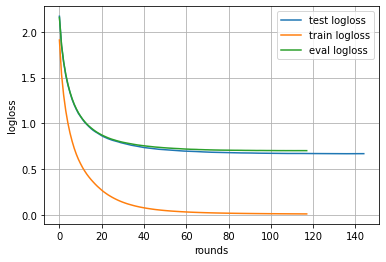

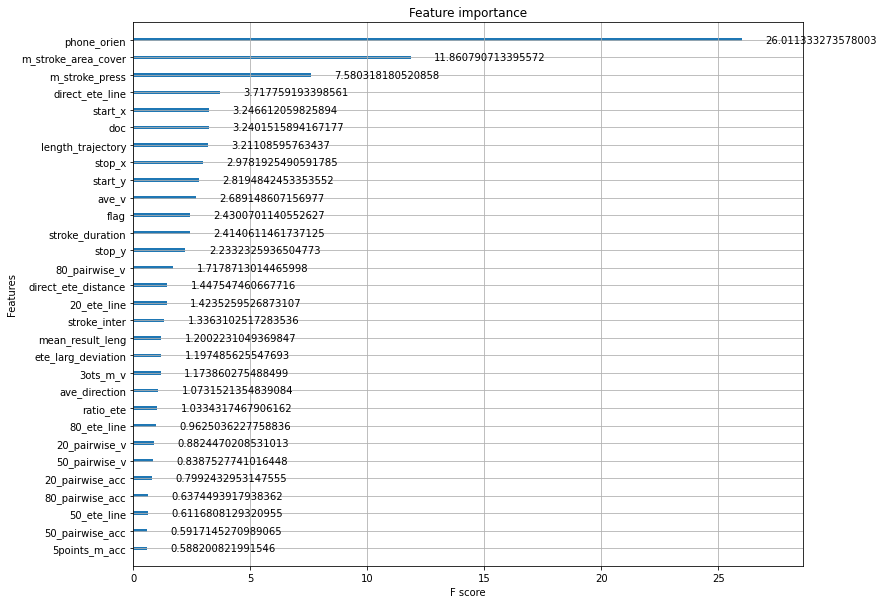

In [189]:
# 多クラス分類
def main3_2_1_m4(df1, nfold):
    
    df = df1.copy()
    
#     a, b, c, d, e = 2, 35, 23, 38, 3
#     df_select = df[df['user'].isin((a, b, c, d, e))].replace({a: 0, b: 1, c: 2, d: 3, e: 4})
    
#     # 教師データの作成
#     y = df_select.user
#     X = df_select.drop("user", 1)

    df2 = df1.copy()
    df2["user"] = df2["user"]-1
    # 教師データの作成
    y = df2.user
    X = df2.drop("user", 1)

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=2021,
                                                        stratify=y)

#     dtrain = xgb.DMatrix(X_train, label=y_train)
#     dtest = xgb.DMatrix(X_test, label=y_test)
    
    # 可視化のために特徴量の名前を渡しておく
    dtrain = xgb.DMatrix(X_train, label=y_train,
                         feature_names=df.columns[1:], silent=1)
    dtest = xgb.DMatrix(X_test, label=y_test,
                        feature_names=df.columns[1:], silent=1)

    print(collections.Counter(y_train))
    
    eval_metric = 'mlogloss'
    
    xgb_params = {
        # 多値分類問題
        'objective': 'multi:softmax',
        # クラス数
        'num_class': 41,
        # 学習用の指標 (Multiclass logloss)
        'eval_metric': eval_metric,
#         'learning_rate': 0.1,
    }
    
    
    # 交差検証する
    history = xgb.cv(xgb_params,
                     dtrain,
                     num_boost_round=1000,
                     early_stopping_rounds=10,
                     nfold=nfold,
                     # 層化分割する
                     stratified=True,
                     # 検証の経過を出力する
                     verbose_eval=10,
                     )
    
    # 学習時に用いる検証用データ
    evals = [(dtrain, 'train'), (dtest, 'eval')]
    # 学習過程を記録するための辞書
    evals_result = {}
    bst = xgb.train(xgb_params,
                    dtrain,
                    num_boost_round=1000,  # ラウンド数を増やしておく
                    early_stopping_rounds=10,
                    evals=evals,
                    evals_result=evals_result,
                    verbose_eval=10,
                    )

    y_pred = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)
#     print(y_pred)
#     y_pred_max = np.argmax(y_pred, axis=1)
    acc = accuracy_score(y_test, y_pred)
#     acc2 = accuracy_score(y_test, y_pred_max)
    print('\nAccuracy:', acc)
#     print('Accuracy_y_pred_max:', acc2)
    
    # 混同行列の計算
    df_accuracy = pd.DataFrame({'va_y': y_test,
                            'y_pred_max': y_pred})
    matrix = pd.crosstab(df_accuracy['va_y'], df_accuracy['y_pred_max'])
    
    print(f'nfold: {nfold}')
    # 学習の課程を折れ線グラフとしてプロットする
#     train_metric = evals_result['train'][eval_metric]
#     plt.plot(train_metric, label='train logloss')
    test_metric = evals_result['eval'][eval_metric]
    plt.plot(test_metric, label='test logloss')
    train_metric = history['train-mlogloss-mean']
    plt.plot(train_metric, label='train logloss')
    eval_metric = history['test-mlogloss-mean']
    plt.plot(eval_metric, label='eval logloss')
    plt.grid()
    plt.legend()
    plt.xlabel('rounds')
    plt.ylabel('logloss')
    plt.show()
    
    
    def plot2(bst):
        # 性能向上に寄与する度合いで重要度をプロットする
        _, ax = plt.subplots(figsize=(12, 10))
        xgb.plot_importance(bst,
                            ax=ax,
                            importance_type='gain',
                            show_values=True)
        plt.show()
    
    plot2(bst)

    return X_train, X_test, y_train, y_test, matrix
if __name__ == '__main__':
    X_train, X_test, y_train, y_test, matrix = main3_2_1_m4(df_drop1, nfold=5)

In [190]:
matrix42 = matrix
matrix42

y_pred_max,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0,40.0
va_y,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,55,0,0,3,0,0,4,0,2,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,2,4,0,0,0,0,1,0,0,0,0,0,1,0,1
1,0,228,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,1,0,4,0,0,0,0,0,0,0,1,1,1,3,0,0
2,0,1,100,0,1,4,0,1,0,6,7,0,0,0,0,1,7,0,3,0,3,0,0,0,1,0,6,0,0,0,0,1,0,0,6,0,2,1,0,0,0
3,2,0,0,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0
4,1,0,1,0,56,1,0,2,3,1,0,1,0,0,0,3,1,1,2,0,0,0,0,0,0,0,5,0,0,0,0,1,0,0,0,0,1,0,0,2,0
5,0,0,3,0,1,96,0,1,0,0,0,1,0,0,0,2,3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,0,2,0
6,4,1,0,1,0,0,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,2,0,6,0,1,0,0,0,1,0,0,0,3,1,0,0
7,0,0,1,0,2,3,0,102,0,0,0,1,1,0,0,2,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,0,0,4,0
8,0,0,0,0,3,1,0,1,77,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,3,0


In [191]:
ab = test(matrix41)
ab.T

[73, 241, 143, 50, 78, 116, 125, 124, 91, 76, 87, 70, 55, 130, 142, 70, 152, 89, 66, 67, 149, 67, 187, 82, 74, 40, 129, 139, 91, 40, 69, 58, 141, 119, 199, 100, 86, 182, 78, 62, 33]
[56, 232, 102, 39, 58, 97, 95, 103, 79, 49, 68, 58, 43, 112, 126, 45, 117, 74, 43, 58, 113, 52, 175, 70, 64, 30, 98, 111, 77, 31, 57, 51, 121, 113, 167, 92, 69, 137, 59, 49, 29]
[76.71232876712328, 96.2655601659751, 71.32867132867133, 78.0, 74.35897435897436, 83.62068965517241, 76.0, 83.06451612903226, 86.81318681318682, 64.47368421052632, 78.16091954022988, 82.85714285714286, 78.18181818181819, 86.15384615384616, 88.73239436619718, 64.28571428571429, 76.97368421052632, 83.14606741573034, 65.15151515151516, 86.56716417910447, 75.83892617449665, 77.61194029850746, 93.58288770053476, 85.36585365853658, 86.48648648648648, 75.0, 75.96899224806202, 79.85611510791367, 84.61538461538461, 77.5, 82.6086956521739, 87.93103448275862, 85.81560283687944, 94.9579831932773, 83.91959798994975, 92.0, 80.23255813953489, 75.2

,0,1
0,1.0,76.712329
1,2.0,96.265560
2,3.0,71.328671
3,4.0,78.000000
4,5.0,74.358974
5,6.0,83.620690
6,7.0,76.000000
7,8.0,83.064516
8,9.0,86.813187
9,10.0,64.473684


In [166]:
matrix41 = matrix
matrix41

y_pred_max,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0,40.0
va_y,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,56,0,1,3,0,0,5,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,1,0,3,0,0,0,0,1,0,0,0,0,0,0,0,1
1,0,232,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,2,0,0,0,1,0,1,0,2,0,0,0,0,0,0,0,1,0,1,1,0,0
2,0,1,102,0,0,4,0,2,0,6,6,0,0,0,0,1,6,0,3,0,5,0,0,0,1,0,7,0,0,0,0,0,0,0,6,0,1,0,0,0,0
3,0,0,0,39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3,0,0,0,0,0,1,0,0,0,0,1,0,0
4,1,0,1,0,58,1,0,3,3,1,0,1,0,0,0,3,0,0,2,0,0,0,0,0,0,0,5,0,0,0,0,1,0,0,1,0,1,0,0,0,0
5,0,0,5,0,1,97,0,0,0,0,0,0,0,0,0,1,2,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,1,0,0,0,0,2,0
6,6,1,0,1,0,0,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,6,0,1,0,0,0,2,0,0,0,3,0,0,0
7,0,0,1,0,3,2,0,103,0,0,0,1,2,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,0,0,4,0
8,0,0,0,0,4,0,0,1,79,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0


In [183]:
def test(cm):
    acc = []
    acc_child = []
    result_ratio = []
    
    for i in range(41):
        count = 0
        child = 0
        for j in range(41):
            count = count + int(cm[i][j])
            if i==j:
                child = int(cm[i][j])
        acc.append(count)
        acc_child.append(child)
        result_ratio.append((child/count)*100)
    
    print(acc)
    print(acc_child)
    print(result_ratio)
    
    n = list(range(1, 41 + 1))
#     print(pd.DataFrame(np.stack([n, result_ratio])))
    return pd.DataFrame(np.stack([n, result_ratio]))
                

aa = test(matrix41)
aa.T

[73, 241, 143, 50, 78, 116, 125, 124, 91, 76, 87, 70, 55, 130, 142, 70, 152, 89, 66, 67, 149, 67, 187, 82, 74, 40, 129, 139, 91, 40, 69, 58, 141, 119, 199, 100, 86, 182, 78, 62, 33]
[56, 232, 102, 39, 58, 97, 95, 103, 79, 49, 68, 58, 43, 112, 126, 45, 117, 74, 43, 58, 113, 52, 175, 70, 64, 30, 98, 111, 77, 31, 57, 51, 121, 113, 167, 92, 69, 137, 59, 49, 29]
[76.71232876712328, 96.2655601659751, 71.32867132867133, 78.0, 74.35897435897436, 83.62068965517241, 76.0, 83.06451612903226, 86.81318681318682, 64.47368421052632, 78.16091954022988, 82.85714285714286, 78.18181818181819, 86.15384615384616, 88.73239436619718, 64.28571428571429, 76.97368421052632, 83.14606741573034, 65.15151515151516, 86.56716417910447, 75.83892617449665, 77.61194029850746, 93.58288770053476, 85.36585365853658, 86.48648648648648, 75.0, 75.96899224806202, 79.85611510791367, 84.61538461538461, 77.5, 82.6086956521739, 87.93103448275862, 85.81560283687944, 94.9579831932773, 83.91959798994975, 92.0, 80.23255813953489, 75.2

,0,1
0,1.0,76.712329
1,2.0,96.265560
2,3.0,71.328671
3,4.0,78.000000
4,5.0,74.358974
5,6.0,83.620690
6,7.0,76.000000
7,8.0,83.064516
8,9.0,86.813187
9,10.0,64.473684


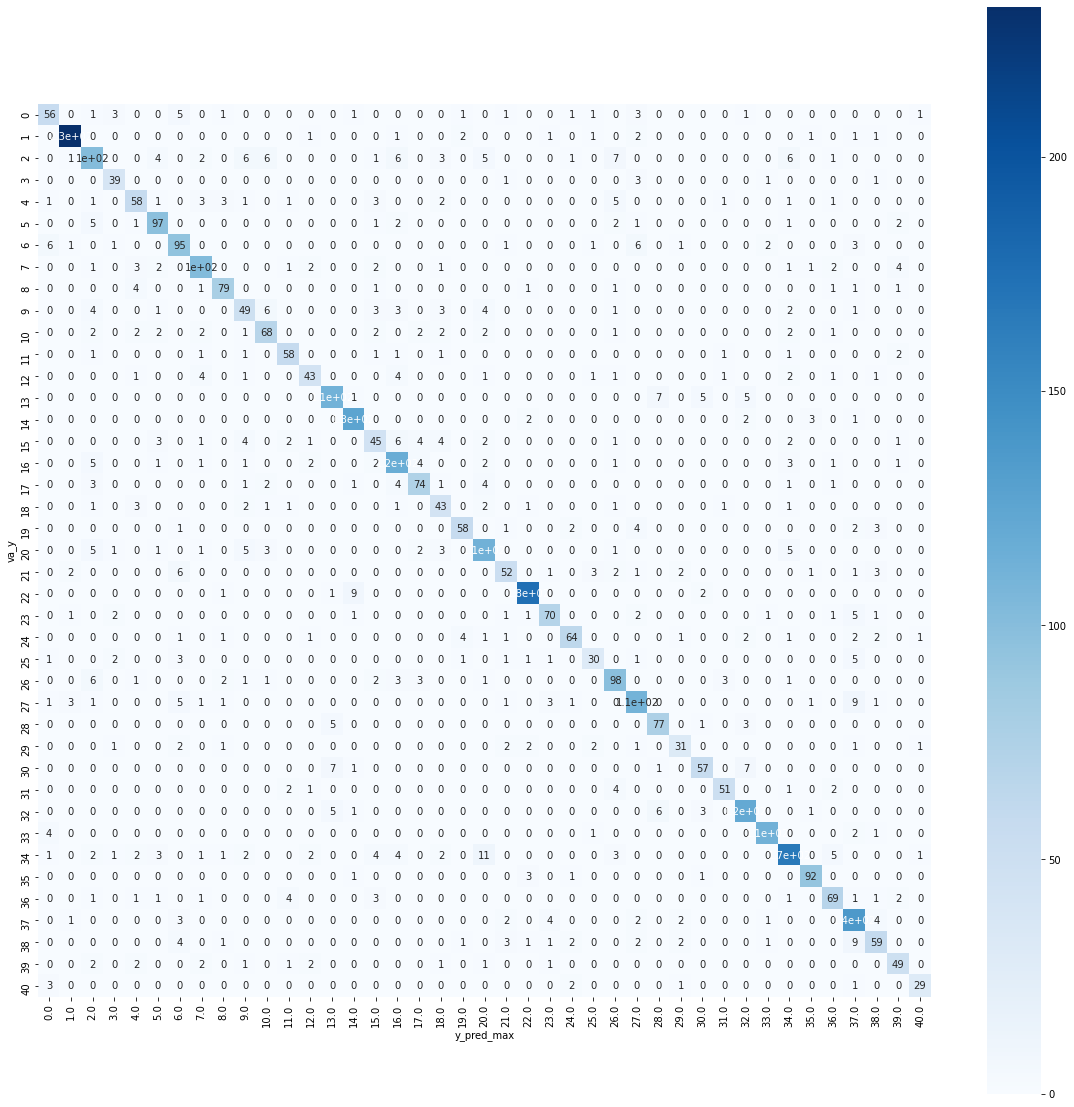

In [165]:
import seaborn as sns
cm = matrix41
plt.figure(figsize=(20, 20))
sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues')
plt.savefig('sklearn_confusion_matrix.png')

Counter({0: 970, 1: 849, 2: 750, 3: 623, 4: 606})
[0]	train-mlogloss:1.42214	eval-mlogloss:1.42878
[10]	train-mlogloss:0.56967	eval-mlogloss:0.61633
[20]	train-mlogloss:0.28147	eval-mlogloss:0.35303
[30]	train-mlogloss:0.16061	eval-mlogloss:0.24620
[40]	train-mlogloss:0.10665	eval-mlogloss:0.19646
[50]	train-mlogloss:0.07332	eval-mlogloss:0.16632
[60]	train-mlogloss:0.05103	eval-mlogloss:0.14604
[70]	train-mlogloss:0.03775	eval-mlogloss:0.13516
[80]	train-mlogloss:0.02873	eval-mlogloss:0.12632
[90]	train-mlogloss:0.02219	eval-mlogloss:0.12113
[100]	train-mlogloss:0.01761	eval-mlogloss:0.11744
[110]	train-mlogloss:0.01426	eval-mlogloss:0.11535
[120]	train-mlogloss:0.01185	eval-mlogloss:0.11293
[130]	train-mlogloss:0.00995	eval-mlogloss:0.11039
[140]	train-mlogloss:0.00852	eval-mlogloss:0.10874
[150]	train-mlogloss:0.00740	eval-mlogloss:0.10763
[160]	train-mlogloss:0.00651	eval-mlogloss:0.10672
[170]	train-mlogloss:0.00580	eval-mlogloss:0.10636
[180]	train-mlogloss:0.00527	eval-mlogloss:

/Users/otaketomomi/anaconda3/envs/TF/lib/python3.7/site-packages/xgboost/core.py:104: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[2. 0. 3. 1. 3. 2. 3. 0. 2. 3. 2. 3. 2. 3. 3. 1. 0. 4. 0. 1. 0. 0. 1. 3.
 4. 0. 0. 2. 0. 3. 1. 0. 1. 0. 2. 4. 1. 2. 1. 1. 0. 4. 1. 2. 3. 4. 1. 1.
 2. 1. 0. 0. 3. 3. 0. 2. 3. 2. 0. 4. 2. 4. 3. 3. 2. 2. 0. 4. 1. 2. 2. 3.
 2. 3. 0. 4. 1. 0. 1. 3. 4. 2. 1. 0. 0. 1. 2. 1. 3. 4. 2. 2. 2. 2. 0. 0.
 1. 0. 3. 4. 1. 1. 2. 0. 3. 0. 1. 0. 3. 2. 4. 3. 0. 0. 0. 3. 2. 4. 4. 4.
 1. 0. 1. 4. 3. 2. 1. 0. 3. 2. 3. 2. 2. 2. 3. 2. 0. 2. 3. 0. 2. 2. 1. 2.
 4. 0. 1. 0. 1. 1. 0. 4. 3. 0. 1. 2. 3. 4. 1. 2. 0. 0. 1. 0. 3. 2. 3. 0.
 2. 0. 1. 3. 2. 2. 3. 0. 3. 2. 2. 4. 2. 1. 1. 2. 4. 1. 1. 4. 1. 3. 1. 1.
 0. 2. 1. 2. 0. 3. 4. 3. 1. 0. 2. 1. 1. 0. 1. 4. 3. 0. 0. 1. 0. 0. 2. 0.
 3. 4. 2. 0. 1. 1. 2. 2. 2. 2. 1. 0. 4. 3. 2. 3. 0. 4. 2. 0. 1. 3. 0. 0.
 0. 3. 1. 2. 1. 1. 0. 0. 0. 3. 2. 2. 1. 2. 2. 0. 1. 2. 0. 0. 0. 0. 4. 1.
 3. 4. 0. 3. 3. 2. 4. 0. 4. 4. 1. 1. 1. 1. 0. 1. 1. 4. 0. 1. 4. 3. 0. 1.
 0. 1. 3. 0. 0. 4. 2. 0. 1. 4. 2. 2. 4. 2. 1. 1. 0. 1. 0. 3. 1. 0. 0. 4.
 4. 1. 2. 1. 0. 2. 0. 3. 1. 1. 4. 0. 3. 4. 2. 1. 3.

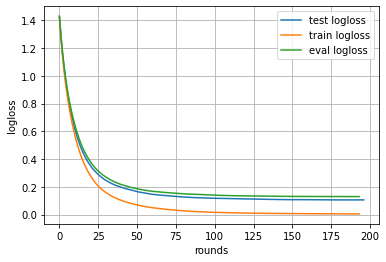

In [155]:
X_train, X_test, y_train, y_test, matrix = main3_2_1_m4(df_drop1, nfold=5)

In [156]:
matrix5 = matrix

y_pred_max,0.0,1.0,2.0,3.0,4.0
va_y,,,,,
0,242,0,0,1,0
1,1,199,0,0,12
2,0,0,186,2,0
3,4,1,0,150,1
4,2,14,0,0,135


### 文献[1]において余分な特徴量を削除して実施

In [185]:
df_dropna2 = df_dropna.copy()
# 使用しない列の削除
df_drop2 = df_dropna2.drop({'phone', 'finger_orien', 'cd_finger_orien', 'doc'}, axis=1)
df_drop2.shape
# df_drop.isnull().sum()

(20848, 30)

#### 41人_docment_id削除

Counter({1: 970, 34: 849, 22: 750, 37: 623, 2: 606, 16: 564, 20: 560, 27: 558, 32: 547, 14: 536, 13: 518, 7: 492, 26: 486, 33: 486, 6: 467, 5: 448, 35: 394, 17: 367, 8: 361, 10: 355, 28: 344, 23: 343, 38: 343, 36: 338, 4: 329, 24: 328, 9: 308, 15: 304, 0: 304, 21: 295, 30: 294, 19: 283, 11: 273, 39: 248, 12: 244, 31: 242, 18: 234, 25: 182, 3: 181, 29: 178, 40: 146})
[0]	train-mlogloss:1.92381	eval-mlogloss:2.19308
[10]	train-mlogloss:0.61337	eval-mlogloss:1.12790
[20]	train-mlogloss:0.32781	eval-mlogloss:0.93879
[30]	train-mlogloss:0.18232	eval-mlogloss:0.86223
[40]	train-mlogloss:0.10718	eval-mlogloss:0.82372
[50]	train-mlogloss:0.06664	eval-mlogloss:0.80136
[60]	train-mlogloss:0.04411	eval-mlogloss:0.78954
[70]	train-mlogloss:0.03148	eval-mlogloss:0.78117
[80]	train-mlogloss:0.02365	eval-mlogloss:0.77655
[90]	train-mlogloss:0.01852	eval-mlogloss:0.77500
[100]	train-mlogloss:0.01497	eval-mlogloss:0.77363
[110]	train-mlogloss:0.01252	eval-mlogloss:0.77440
[114]	train-mlogloss:0.01177	e

/Users/otaketomomi/anaconda3/envs/TF/lib/python3.7/site-packages/xgboost/core.py:104: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



Accuracy: 0.7788968824940048
nfold: 5


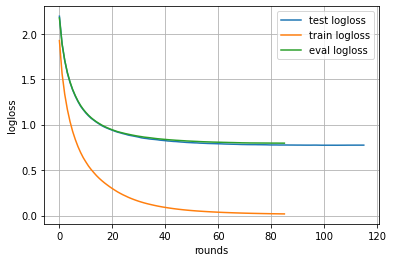

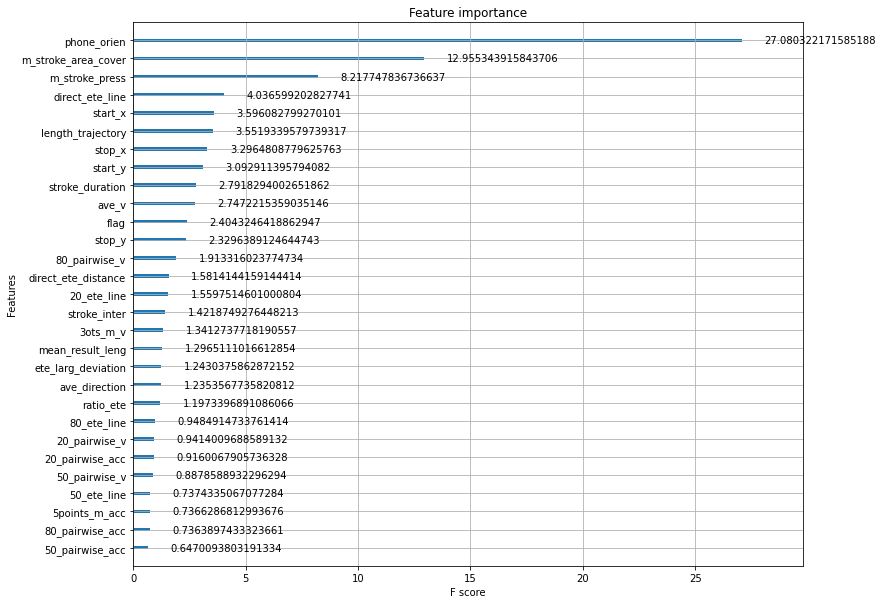

In [192]:

X_train, X_test, y_train, y_test, matrix322_41 = main3_2_1_m4(df_drop2, nfold=5)

In [193]:
matrix322_41

y_pred_max,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0,40.0
va_y,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,53,1,0,3,0,0,6,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,1,0,2,0,0,0,0,1,3,1,0,0,0,0,0,0
1,0,227,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,1,0,4,0,0,0,0,0,0,0,1,1,3,1,0,0
2,0,1,95,0,2,4,0,2,0,5,4,0,1,0,0,2,7,2,2,0,5,0,0,0,1,0,5,0,0,0,0,1,0,0,11,0,1,0,0,0,0
3,2,0,0,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,3,0,0,0,0,0,1,0,0,0,0,1,0,0
4,1,0,2,0,51,0,0,2,2,0,0,2,0,0,0,3,1,1,3,0,0,0,0,0,0,0,9,0,0,0,0,1,0,0,1,0,2,0,0,1,0
5,0,0,4,0,1,88,0,1,1,0,0,1,2,0,0,1,4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,3,1,2,0
6,6,3,0,1,0,0,88,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,2,0,6,0,2,0,0,0,1,0,0,0,5,1,0,0
7,0,0,1,0,3,3,0,99,0,0,0,1,0,0,0,4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,3,0,0,6,0
8,0,0,0,0,3,1,0,0,78,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,2,1,0,0,0


In [194]:
bb = test(matrix322_41)
bb.T

[67, 256, 144, 44, 76, 116, 126, 123, 88, 82, 81, 73, 59, 132, 135, 76, 152, 80, 65, 67, 142, 73, 190, 78, 70, 44, 126, 142, 92, 38, 62, 59, 145, 120, 204, 95, 87, 186, 78, 64, 33]
[53, 227, 95, 35, 51, 88, 88, 99, 78, 52, 64, 58, 41, 109, 119, 44, 105, 62, 38, 57, 102, 52, 176, 67, 59, 28, 86, 109, 78, 28, 51, 51, 121, 110, 152, 88, 65, 130, 54, 47, 31]
[79.1044776119403, 88.671875, 65.97222222222221, 79.54545454545455, 67.10526315789474, 75.86206896551724, 69.84126984126983, 80.48780487804879, 88.63636363636364, 63.41463414634146, 79.01234567901234, 79.45205479452055, 69.49152542372882, 82.57575757575758, 88.14814814814815, 57.89473684210527, 69.07894736842105, 77.5, 58.46153846153847, 85.07462686567165, 71.83098591549296, 71.23287671232876, 92.63157894736842, 85.8974358974359, 84.28571428571429, 63.63636363636363, 68.25396825396825, 76.76056338028168, 84.78260869565217, 73.68421052631578, 82.25806451612904, 86.4406779661017, 83.44827586206897, 91.66666666666666, 74.50980392156863, 9

,0,1
0,1.0,79.104478
1,2.0,88.671875
2,3.0,65.972222
3,4.0,79.545455
4,5.0,67.105263
5,6.0,75.862069
6,7.0,69.841270
7,8.0,80.487805
8,9.0,88.636364
9,10.0,63.414634


Counter({0: 970, 1: 849, 2: 750, 3: 623, 4: 606})
[0]	train-mlogloss:1.09524	eval-mlogloss:1.11747
[10]	train-mlogloss:0.15195	eval-mlogloss:0.25005
[20]	train-mlogloss:0.05250	eval-mlogloss:0.16633
[30]	train-mlogloss:0.02423	eval-mlogloss:0.14779
[40]	train-mlogloss:0.01315	eval-mlogloss:0.14214
[50]	train-mlogloss:0.00853	eval-mlogloss:0.14118
[60]	train-mlogloss:0.00604	eval-mlogloss:0.14175
[65]	train-mlogloss:0.00528	eval-mlogloss:0.14223

Accuracy: 0.9473684210526315
nfold: 5


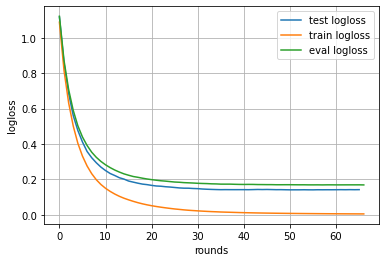

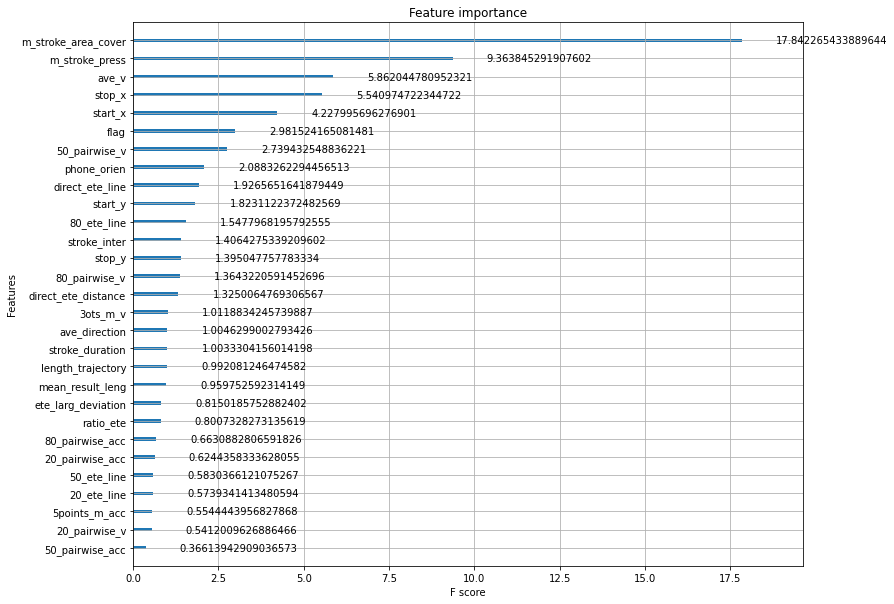

In [198]:
X_train, X_test, y_train, y_test = main3_2_1_m3(df_drop2, nfold=5)

In [202]:
df_dropna3 = df_dropna.copy()
# 使用しない列の削除
df_drop3 = df_dropna3.drop({'phone', 'finger_orien', 'cd_finger_orien', 'phone_orien', 'doc'}, axis=1)
df_drop3.shape
# df_drop.isnull().sum()

(20848, 29)

Counter({1: 970, 34: 849, 22: 750, 37: 623, 2: 606, 16: 564, 20: 560, 27: 558, 32: 547, 14: 536, 13: 518, 7: 492, 26: 486, 33: 486, 6: 467, 5: 448, 35: 394, 17: 367, 8: 361, 10: 355, 28: 344, 23: 343, 38: 343, 36: 338, 4: 329, 24: 328, 9: 308, 15: 304, 0: 304, 21: 295, 30: 294, 19: 283, 11: 273, 39: 248, 12: 244, 31: 242, 18: 234, 25: 182, 3: 181, 29: 178, 40: 146})
[0]	train-mlogloss:1.93359	eval-mlogloss:2.19602
[10]	train-mlogloss:0.62622	eval-mlogloss:1.13563
[20]	train-mlogloss:0.33198	eval-mlogloss:0.93832
[30]	train-mlogloss:0.18641	eval-mlogloss:0.86079
[40]	train-mlogloss:0.11069	eval-mlogloss:0.81982
[50]	train-mlogloss:0.06838	eval-mlogloss:0.79490
[60]	train-mlogloss:0.04631	eval-mlogloss:0.78399
[70]	train-mlogloss:0.03270	eval-mlogloss:0.77708
[80]	train-mlogloss:0.02437	eval-mlogloss:0.77263
[90]	train-mlogloss:0.01898	eval-mlogloss:0.77024
[100]	train-mlogloss:0.01527	eval-mlogloss:0.77053
[101]	train-mlogloss:0.01495	eval-mlogloss:0.77020


/Users/otaketomomi/anaconda3/envs/TF/lib/python3.7/site-packages/xgboost/core.py:104: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



Accuracy: 0.779136690647482
nfold: 5


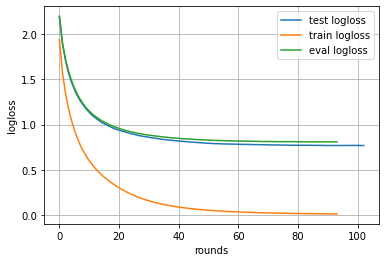

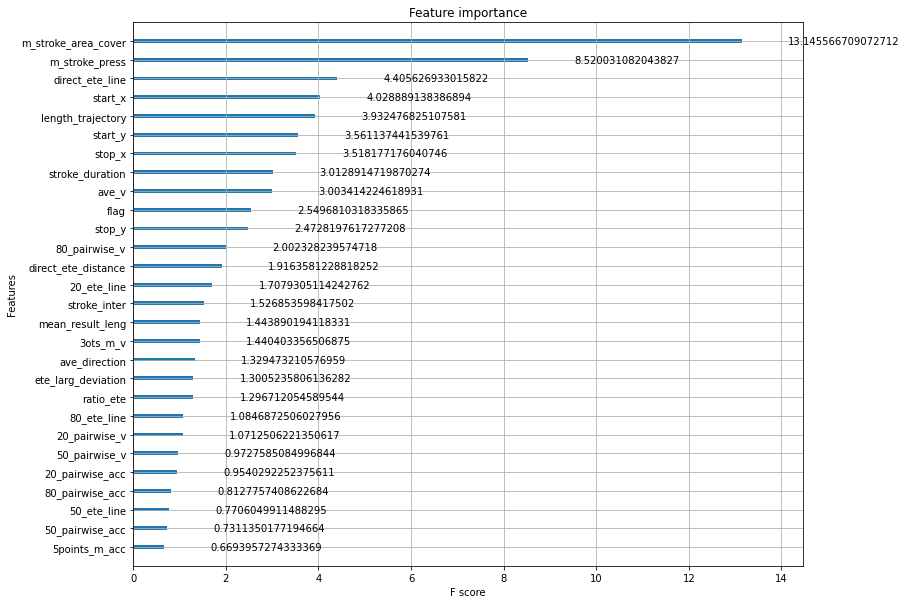

In [203]:
X_train, X_test, y_train, y_test, matrix3221_41 = main3_2_1_m4(df_drop3, nfold=5)

### ストロークの方向ごとに実施

## 問題点2について

### ひとまずaccuracyの高い順に追加して変化をとりあえずみてみる(特徴量数は27個)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20399 entries, 0 to 20398
Data columns (total 67 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   user                  20399 non-null  int64  
 1   doc                   20399 non-null  int64  
 2   stroke_inter          20399 non-null  float64
 3   stroke_duration       20399 non-null  float64
 4   start_x               20399 non-null  float64
 5   start_y               20399 non-null  float64
 6   stop_x                20399 non-null  float64
 7   stop_y                20399 non-null  float64
 8   direct_ete_distance   20399 non-null  float64
 9   mean_result_leng      20399 non-null  float64
 10  direct_ete_line       20399 non-null  float64
 11  20_pairwise_v         20399 non-null  float64
 12  50_pairwise_v         20399 non-null  float64
 13  80_pairwise_v         20399 non-null  float64
 14  20_pairwise_acc       20399 non-null  float64
 15  50_pairwise_acc       20399 non-null  float64
 16  80_pairwise_acc       20399 non-null  float64
 17  3ots_m_v              20399 non-null  float64
 18  ete_larg_deviation    20399 non-null  float64
 19  20_ete_line           20399 non-null  float64
 20  50_ete_line           20399 non-null  float64
 21  80_ete_line           20399 non-null  float64
 22  ave_direction         20399 non-null  float64
 23  length_trajectory     20399 non-null  float64
 24  ratio_ete             20399 non-null  float64
 25  ave_v                 20399 non-null  float64
 26  5points_m_acc         20399 non-null  float64
 27  m_stroke_press        20399 non-null  float64
 28  m_stroke_area_cover   20399 non-null  float64
 29  stroke_inter2         20399 non-null  float64
 30  stroke_duration2      20399 non-null  float64
 31  start_x2              20399 non-null  float64
 32  start_y2              20399 non-null  float64
 33  stop_x2               20399 non-null  float64
 34  stop_y2               20399 non-null  float64
 35  direct_ete_distance2  20399 non-null  float64
 36  mean_result_leng2     20399 non-null  float64
 37  direct_ete_line2      20399 non-null  float64
 38  20_pairwise_v2        20399 non-null  float64
 39  50_pairwise_v2        20399 non-null  float64
 40  80_pairwise_v2        20399 non-null  float64
 41  20_pairwise_acc2      20399 non-null  float64
 42  50_pairwise_acc2      20399 non-null  float64
 43  80_pairwise_acc2      20399 non-null  float64
 44  3ots_m_v2             20399 non-null  float64
 45  ete_larg_deviation2   20399 non-null  float64
 46  20_ete_line2          20399 non-null  float64
 47  50_ete_line2          20399 non-null  float64
 48  80_ete_line2          20399 non-null  float64
 49  ave_direction2        20399 non-null  float64
 50  length_trajectory2    20399 non-null  float64
 51  ratio_ete2            20399 non-null  float64
 52  ave_v2                20399 non-null  float64
 53  5points_m_acc2        20399 non-null  float64
 54  m_stroke_press2       20399 non-null  float64
 55  m_stroke_area_cover2  20399 non-null  float64
 56  2stroke_a             20399 non-null  float64
 57  2stroke_distance      20399 non-null  float64
 58  2stroke_time          20399 non-null  float64
 59  2stroke_v             20399 non-null  float64
 60  a_stroke_inter        20399 non-null  float64
 61  d_stroke_inter        20399 non-null  float64
 62  outside_a             20399 non-null  float64
 63  outside_d             20399 non-null  float64
 64  outside_v             20399 non-null  float64
 65  v_stroke_inter        20399 non-null  float64
 66  multi_flag            20399 non-null  int64  
dtypes: float64(64), int64(3)
memory usage: 10.4 MB

# その他

## 参考サイトなど
[1] 【Python】XGBoostの実装方法と特徴量重要度, HTOMblog (URL)https://htomblog.com/python-xgboost (最終閲覧日: 2021/06/16)   

[2] Python: XGBoost を使ってみる, URL:https://blog.amedama.jp/entry/2019/01/29/235642   

[3] Xgboost : feature_importanceのimportance_type算出方法, URL:https://qiita.com/hand10ryo/items/ed1e511b5236f7bfe606   
[4] xgboost のパラメータ, URL:https://puyokw.hatenablog.com/entry/2015/04/11/040941   
[5] XGBoostのアルゴリズムを論文を読んで解説, URL: https://www.dskomei.com/entry/2019/12/23/231333https://www.dskomei.com/entry/2019/12/23/231333  

[6] Python XGBoost の変数重要度プロット / 可視化の実装, URL:https://sinhrks.hatenablog.com/entry/2015/08/27/000235   
[7] Python: LightGBM の決定木を可視化して分岐を追ってみる, URL:https://blog.amedama.jp/entry/lgbm-tree-plot   

[8] 【Python覚書】XGBoostで多値分類問題を解いてみる, URL:https://potesara-tips.com/xgboost-holdout/#toc13

[9] xgboostで機能の重要性を取得する方法は？, URL:https://www.it-swarm-ja.com/ja/python/xgboost%E3%81%A7%E6%A9%9F%E8%83%BD%E3%81%AE%E9%87%8D%E8%A6%81%E6%80%A7%E3%82%92%E5%8F%96%E5%BE%97%E3%81%99%E3%82%8B%E6%96%B9%E6%B3%95%E3%81%AF%EF%BC%9F/825940507/
get_scoreについて   


## なんか出てきたエラーたち

XGBoostをインストールするとき   
XGBoostError: XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed (vcomp140.dll or libgomp-1.dll for Windows, libomp.dylib for Mac OSX, libgomp.so for Linux and other UNIX-like OSes). Mac OSX users: Run `brew install libomp` to install OpenMP runtime.
  * You are running 32-bit Python on a 64-bit OS
Error message(s): ['dlopen(/Users/otaketomomi/anaconda3/envs/TF/lib/python3.7/site-packages/xgboost/lib/libxgboost.dylib, 6): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib\n  Referenced from: /Users/otaketomomi/anaconda3/envs/TF/lib/python3.7/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: image not found']

→brew install libompで解決した

[pip install graphviz]

In [65]:
#conda install nodejs

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.1
  latest version: 4.10.1

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /Users/otaketomomi/anaconda3/envs/TF

  added / updated specs:
    - nodejs


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2021.5.25  |       hecd8cb5_1         117 KB
    certifi-2021.5.30          |   py37hecd8cb5_0         141 KB
    icu-68.1                   |       h23ab428_0        24.7 MB
    libuv-1.40.0               |       haf1e3a3_0         421 KB
    nodejs-14.8.0              |       hec0b97e_0        12.7 MB
    openssl-1.1.1k             |       h9ed2024_0         3.5 MB
    ------------------------------------------------------------
                                           Total:        41.6 MB

The 

In [3]:
#!jupyter-labextension list      

JupyterLab v2.2.6<br>
No installed extensions

In [2]:
#conda install -c conda-forge jupyterlab=3

In [4]:
#!jupyter-labextension list

JupyterLab v3.0.16